In [1]:
# === Cell 0: Imports, paths, compact style ===================================
from __future__ import annotations
from pathlib import Path
import json, math, itertools, warnings
from typing import Dict, List, Tuple, Sequence, Iterable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

warnings.filterwarnings("ignore")

# Repo paths
CWD = Path.cwd()
ROOT = CWD if (CWD / "data").exists() else CWD.parent
SEQ_DIR  = ROOT / "data" / "sequences"
PROC_DIR = ROOT / "data" / "processed"
OUT_DIR  = ROOT / "assets" / "figs"
TAB_DIR  = ROOT / "assets" / "tables"
for p in [OUT_DIR, TAB_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# Files
STATES_NPY     = SEQ_DIR / "states_10min.npy"
GRID_IDS_CSV   = SEQ_DIR / "grid_ids.csv"
CATALOG_JSON   = SEQ_DIR / "state_catalog.json"
SUBGROUPS_PARQ = PROC_DIR / "subgroups.parquet"

# Compact figure defaults (paper-friendly)
INCH_COL1 = 6  # one-column width
INCH_COL2 = 12   # two-column width (if needed)

plt.rcParams.update({
    "figure.figsize": (INCH_COL1, 2.0),
    "figure.dpi": 200,
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlesize": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 8,
    "lines.linewidth": 1.4,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.03,
})


In [2]:
# === Cell 1: Load data =======================================================
states = np.load(STATES_NPY)                         # [N, 144] integer state IDs
ids_df = pd.read_csv(GRID_IDS_CSV, dtype={"TUCASEID":"int64"})
with open(CATALOG_JSON, "r") as f:
    catalog = json.load(f)

id_to_sub = {int(k): v for k, v in catalog["id_to_sub"].items()}
sub_to_id = {k: int(v) for k, v in catalog["sub_to_id"].items()}
K = 1 + max(id_to_sub)  # assumes 0..K-1
N, T = states.shape

meta = pd.read_parquet(SUBGROUPS_PARQ)
meta_aligned = ids_df.merge(meta, on="TUCASEID", how="left")

# Survey weights (robust scaling for ATUS-like magnitudes)
if "TUFNWGTP" in meta_aligned.columns:
    w_raw = meta_aligned["TUFNWGTP"].astype("float64").fillna(0)
    w = w_raw / 1e4 if w_raw.median() > 1e6 else w_raw
else:
    w = pd.Series(1.0, index=meta_aligned.index, dtype="float64")

def _norm(s): 
    return meta_aligned.get(s, pd.Series(["Unknown"]*len(meta_aligned))).astype("string").str.strip()

region      = _norm("region")
sex         = _norm("sex")
employment  = _norm("employment")
day_type    = _norm("day_type")
hh_size     = _norm("hh_size_band")
quarter     = _norm("quarter")
month       = _norm("month")

# Key states (auto-pick if present)
CAND_KEY = ["SLEEP","COOKING","DISHWASHING","LAUNDRY_IRON","EAT_DRINK",
            "PERSONAL_CARE","SCREENS_LEISURE","QUIET_SOCIAL","EXERCISE_NO_MACHINE","OUT_OF_HOME"]
KEY_STATES = [s for s in CAND_KEY if s in sub_to_id]

print(f"N={N}, T={T}, K={K}")
display(meta_aligned.head(3))


N=252808, T=144, K=15


,TUCASEID,region,quarter,employment,hh_size_band,month,sex,day_type,TUFNWGTP
0,20030100013280,West,Q1,Unemployed,3,1,Male,Weekday,8155.462672
1,20030100013344,West,Q1,Employed,4plus,1,Female,Weekend,1735.322528
2,20030100013352,West,Q1,Unknown,2,1,Female,Weekend,3830.527483


In [3]:
# === Cell 2: Core helpers ====================================================
def to_table(df: pd.DataFrame, name: str) -> Tuple[Path, Path]:
    csv_path = TAB_DIR / f"{name}.csv"
    tex_path = TAB_DIR / f"{name}.tex"
    df.to_csv(csv_path, index=False)
    try:
        tex = df.to_latex(index=False, float_format="%.3f")
        tex_path.write_text(tex)
    except Exception:
        pass
    return csv_path, tex_path

def label_for(sid: int) -> str:
    return id_to_sub.get(int(sid), f"STATE_{sid}")

def slot_minutes():
    return np.arange(144) * 10

minutes = slot_minutes()

def hour_ticks(x_min):
    hrs = np.arange(0, 25, 2)
    xt = hrs * 60
    xl = [f"{h%24:02d}:00" for h in hrs]
    return xt, xl

def weighted_occupancy(states: np.ndarray, weights: np.ndarray, K: int) -> np.ndarray:
    N, T = states.shape
    out = np.zeros((K, T), dtype="float64")
    for t in range(T):
        col = states[:, t]
        np.add.at(out[:, t], col, weights)
    denom = weights.sum()
    return out / denom if denom > 0 else out

def weighted_transition_matrix(states: np.ndarray, weights: np.ndarray, K: int, exclude_id: int|None=0):
    counts = np.zeros((K, K), dtype="float64")
    for n in range(states.shape[0]):
        seq = states[n]
        src, dst = seq[:-1], seq[1:]
        if exclude_id is not None:
            valid = (src != exclude_id) & (dst != exclude_id)
            src, dst = src[valid], dst[valid]
        np.add.at(counts, (src, dst), weights[n])
    row_sums = counts.sum(axis=1, keepdims=True)
    probs = np.divide(counts, row_sums, where=row_sums > 0)
    return counts, probs

def dwell_time_runs(states: np.ndarray, target_state: int) -> List[int]:
    runs = []
    for row in states:
        x = (row == target_state).astype(np.int8)
        if x.any():
            diff = np.diff(np.concatenate(([0], x, [0])))
            starts = np.where(diff == 1)[0]
            ends   = np.where(diff == -1)[0]
            runs.extend((ends - starts).tolist())
    return runs

def nonparametric_hazard_from_runs(runs: List[int]) -> pd.DataFrame:
    if not runs:
        return pd.DataFrame({"t_slots":[],"at_risk":[],"events":[],"hazard":[],"survival":[],"t_min":[]})
    counts = np.bincount(runs)
    max_t = len(counts)-1
    at_risk, events = [], []
    total = len(runs)
    cum_lt = 0
    for t in range(1, max_t+1):
        cum_lt += counts[t-1]
        ar = total - cum_lt
        ev = counts[t]
        at_risk.append(ar); events.append(ev)
    at_risk = np.array(at_risk, dtype=float)
    events  = np.array(events, dtype=float)
    hazard = np.divide(events, at_risk, out=np.zeros_like(events), where=at_risk>0)
    survival = np.cumprod(1 - hazard)
    t_slots = np.arange(1, max_t+1)
    return pd.DataFrame({"t_slots":t_slots,"at_risk":at_risk,"events":events,
                         "hazard":hazard,"survival":survival,"t_min":t_slots*10.0})

def frobenius(a: np.ndarray, b: np.ndarray) -> float:
    d = a - b
    return float(np.sqrt((d*d).sum()))

# Robust boolean mask (avoids NA/object errors)
def mask_eq(series: pd.Series, level) -> np.ndarray:
    m = (series == level)
    if not hasattr(m, "fillna"):
        m = pd.Series(m, index=series.index)
    return m.fillna(False).to_numpy(dtype=bool)


In [4]:
# === Cell 3: Subplot & pagination helpers ===================================
from math import ceil

def make_grid(nrows=2, ncols=3, colwidth="one", h_per_row=1.25, sharex=False, sharey=False, constrained=True):
    W = INCH_COL1 if colwidth == "one" else INCH_COL2
    H = max(1.4, nrows * h_per_row)
    fig, axs = plt.subplots(nrows, ncols, figsize=(W, H), sharex=sharex, sharey=sharey,
                            constrained_layout=constrained)
    if isinstance(axs, np.ndarray):
        if axs.ndim == 1:
            axs = np.expand_dims(axs, 0)
    else:
        axs = np.array([[axs]])
    return fig, axs

def paginate(items: Sequence, per_page: int) -> Iterable[Sequence]:
    for i in range(0, len(items), per_page):
        yield items[i:i+per_page]

def hide_unused(axs):
    for ax in axs.ravel():
        if not ax.has_data():
            ax.axis("off")


In [5]:
# === Cell 4: Covariate level distributions ==================================
def cat_table(series: pd.Series, weights: pd.Series, name: str) -> pd.DataFrame:
    df = (pd.DataFrame({"cat": series, "w": weights})
            .groupby("cat", dropna=False)["w"]
            .agg(n="count", wsum="sum")
            .reset_index()
            .sort_values("wsum", ascending=False))
    df["wshare"] = df["wsum"] / df["wsum"].sum()
    to_table(df, f"levels_{name}")
    return df

levels = {
    "region": cat_table(region, w, "region"),
    "sex": cat_table(sex, w, "sex"),
    "employment": cat_table(employment, w, "employment"),
    "day_type": cat_table(day_type, w, "day_type"),
    "hh_size_band": cat_table(hh_size, w, "hh_size_band"),
    "quarter": cat_table(quarter, w, "quarter"),
    "month": cat_table(month, w, "month"),
}
for k, df in levels.items():
    print(f"\n{k.upper()}"); display(df.head(10))



REGION


,cat,n,wsum,wshare
2,South,92823,7.034580e+08,0.367517
0,Midwest,61125,4.528418e+08,0.236584
3,West,55336,4.206119e+08,0.219746
1,Northeast,43524,3.371722e+08,0.176153



SEX


,cat,n,wsum,wshare
0,Female,140756,9.864235e+08,0.51535
1,Male,112052,9.276603e+08,0.48465



EMPLOYMENT


,cat,n,wsum,wshare
0,Employed,213226,1.599302e+09,0.835545
3,Unknown,31368,2.504173e+08,0.130829
1,NotInLF,3732,3.226278e+07,0.016855
2,Unemployed,4482,3.210137e+07,0.016771



DAY_TYPE


,cat,n,wsum,wshare
0,Weekday,126264,1.367039e+09,0.7142
1,Weekend,126544,5.470446e+08,0.2858



HH_SIZE_BAND


,cat,n,wsum,wshare
3,4plus,74776,6.429965e+08,0.335929
1,2,72749,6.314946e+08,0.329920
2,3,42751,3.558241e+08,0.185898
0,1,62532,2.837687e+08,0.148253



QUARTER


,cat,n,wsum,wshare
3,Q4,60804,4.839138e+08,0.252817
2,Q3,61880,4.827002e+08,0.252183
1,Q2,62107,4.762415e+08,0.248809
0,Q1,68017,4.712283e+08,0.246190



MONTH


,cat,n,wsum,wshare
0,1,25651,1.762734e+08,0.092093
1,10,21008,1.658563e+08,0.086651
9,7,20946,1.638071e+08,0.085580
10,8,20882,1.633876e+08,0.085361
6,4,20604,1.631656e+08,0.085245
3,12,19746,1.618813e+08,0.084574
7,5,20441,1.603193e+08,0.083758
5,3,22288,1.574837e+08,0.082276
2,11,20050,1.561762e+08,0.081593
11,9,20052,1.555055e+08,0.081243


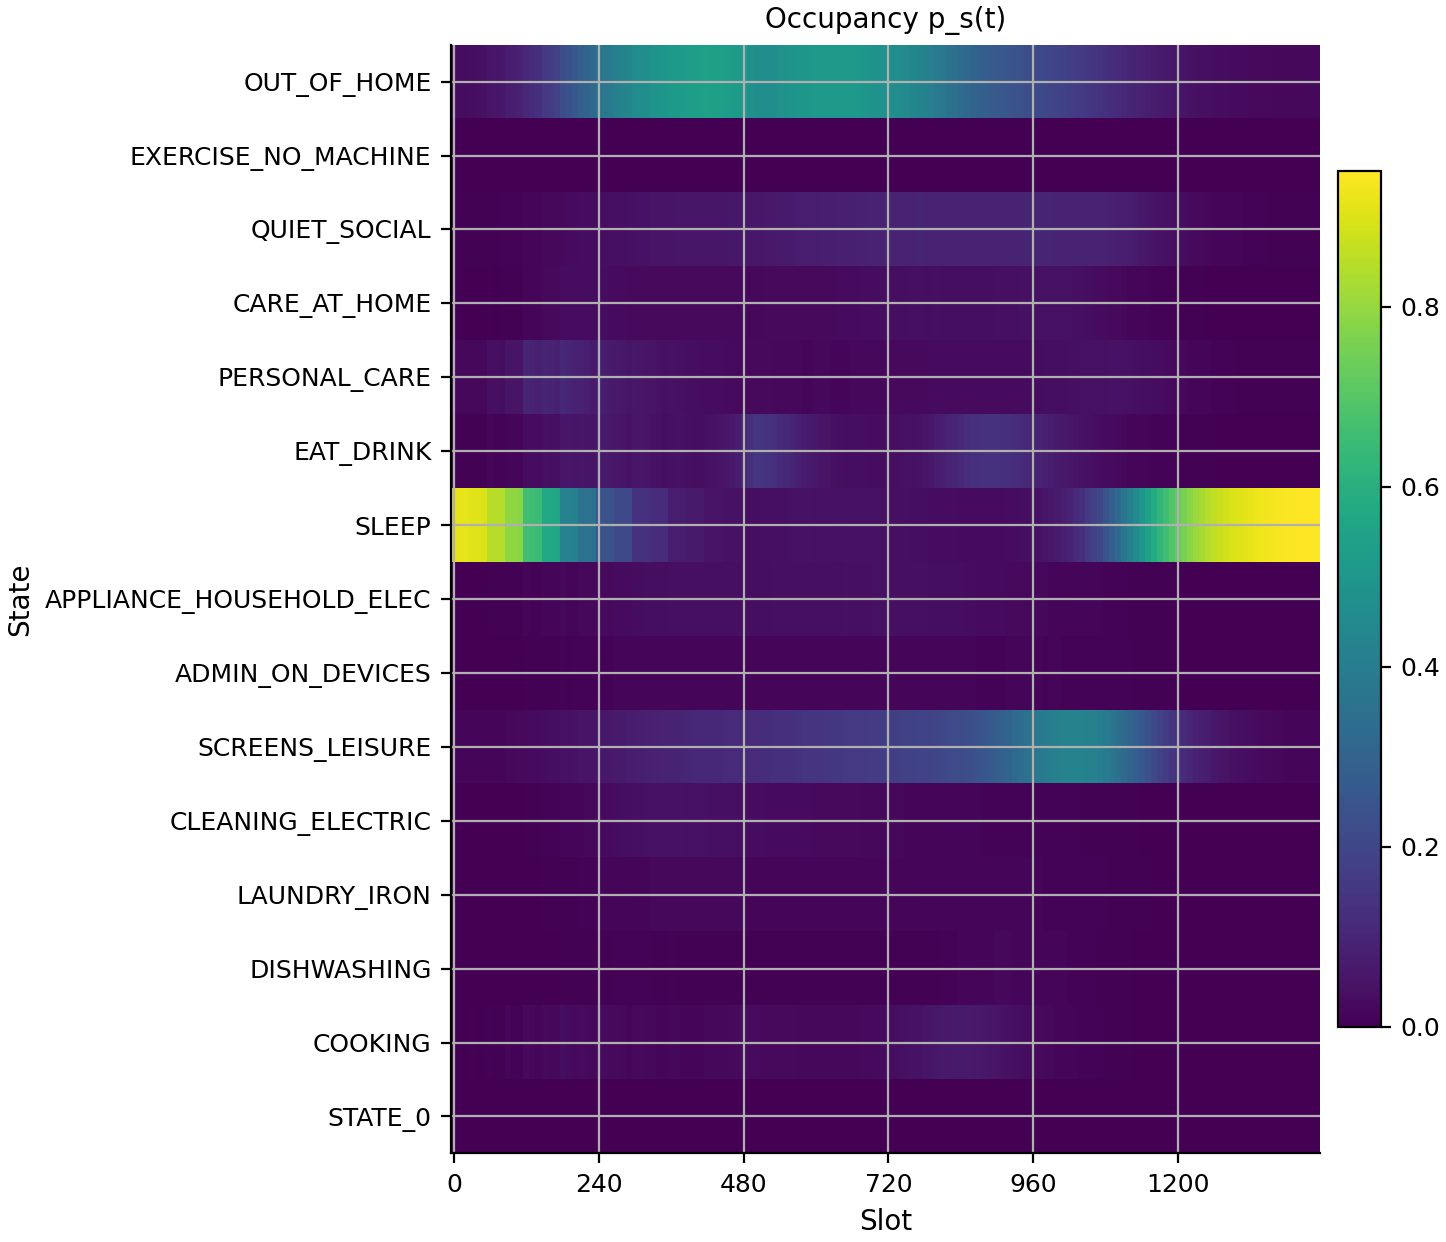

,state_id,state,share,minutes_per_day
8,8,SLEEP,0.342106,492.633306
14,14,OUT_OF_HOME,0.270535,389.570192
5,5,SCREENS_LEISURE,0.147126,211.861238
12,12,QUIET_SOCIAL,0.054569,78.579891
9,9,EAT_DRINK,0.047960,69.062068
10,10,PERSONAL_CARE,0.033612,48.401425
11,11,CARE_AT_HOME,0.022193,31.957403
7,7,APPLIANCE_HOUSEHOLD_ELEC,0.021544,31.023728
1,1,COOKING,0.020022,28.831525
4,4,CLEANING_ELECTRIC,0.015318,22.058449


In [6]:
# === Cell 5: Overall occupancy & top states =================================
occ_all = weighted_occupancy(states, w.to_numpy("float64"), K)

# Small heatmap (tick every ~8 labels)
labels = np.array([label_for(i) for i in range(K)])
step = max(1, K // 8)
fig, ax = plt.subplots(figsize=(INCH_COL1, INCH_COL1*1.2))
im = ax.imshow(occ_all, origin="lower", aspect="auto")
ax.set_title("Occupancy p_s(t)")
ax.set_xlabel("Slot"); ax.set_ylabel("State")
ax.set_xticks(np.arange(0, 144, 24)); ax.set_xticklabels((np.arange(0, 144, 24)*10).astype(int))
ax.set_yticks(np.arange(0, K, step)); ax.set_yticklabels(labels[::step])
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
fig.savefig(OUT_DIR / "occupancy_heatmap_small.png", dpi=300)
plt.show()

# Top states by time-share
share = occ_all.mean(axis=1)
top_df = (pd.DataFrame({
    "state_id": np.arange(K),
    "state": labels,
    "share": share,
    "minutes_per_day": share * 144 * 10
}).sort_values("share", ascending=False).head(min(15, K)))
to_table(top_df, "overall_top_time_share")
display(top_df)


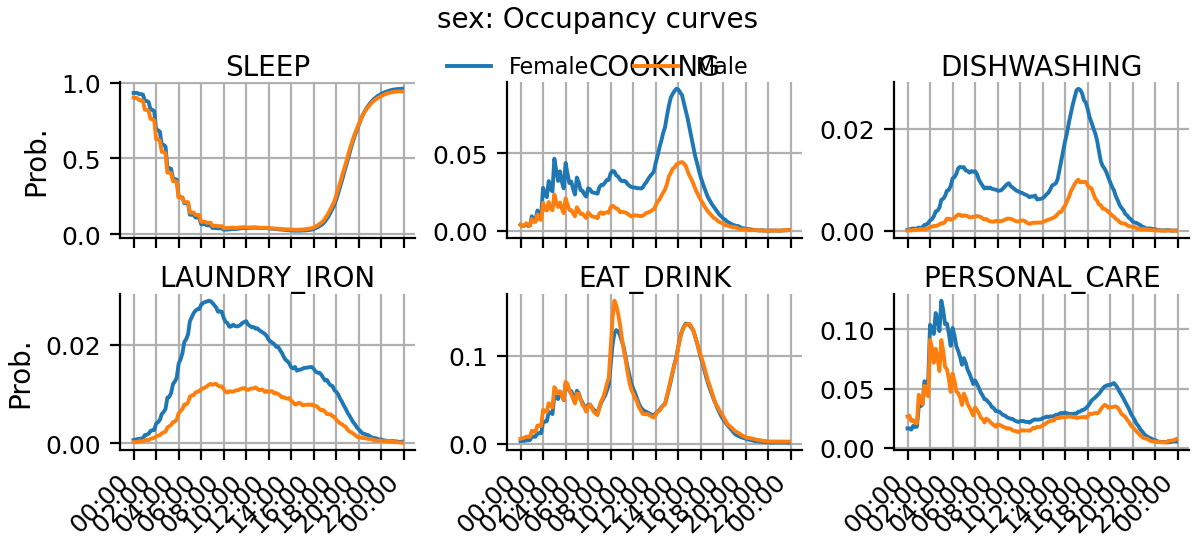

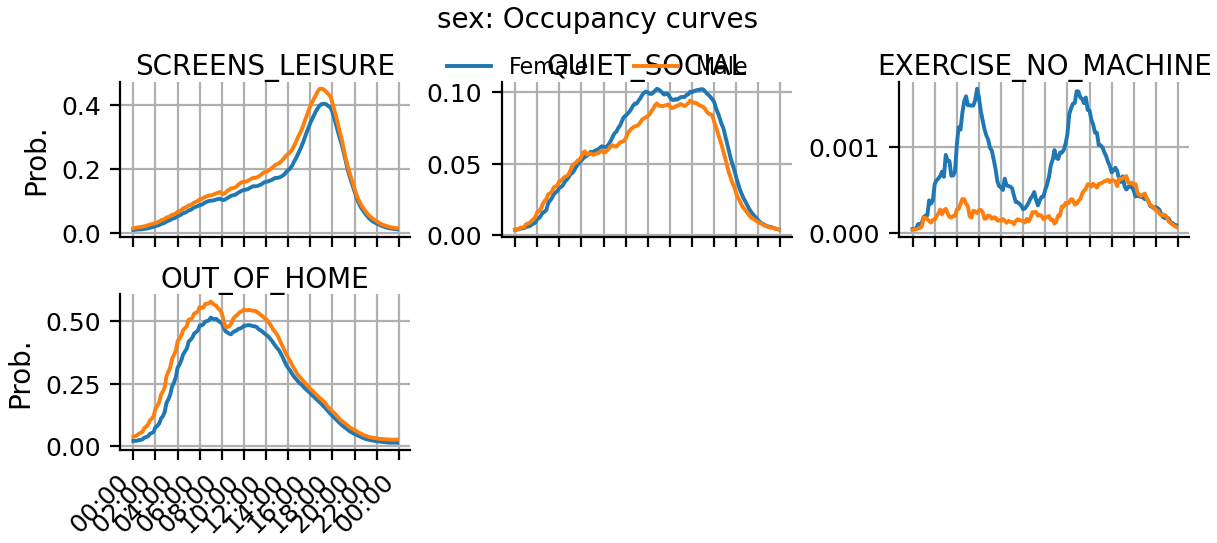

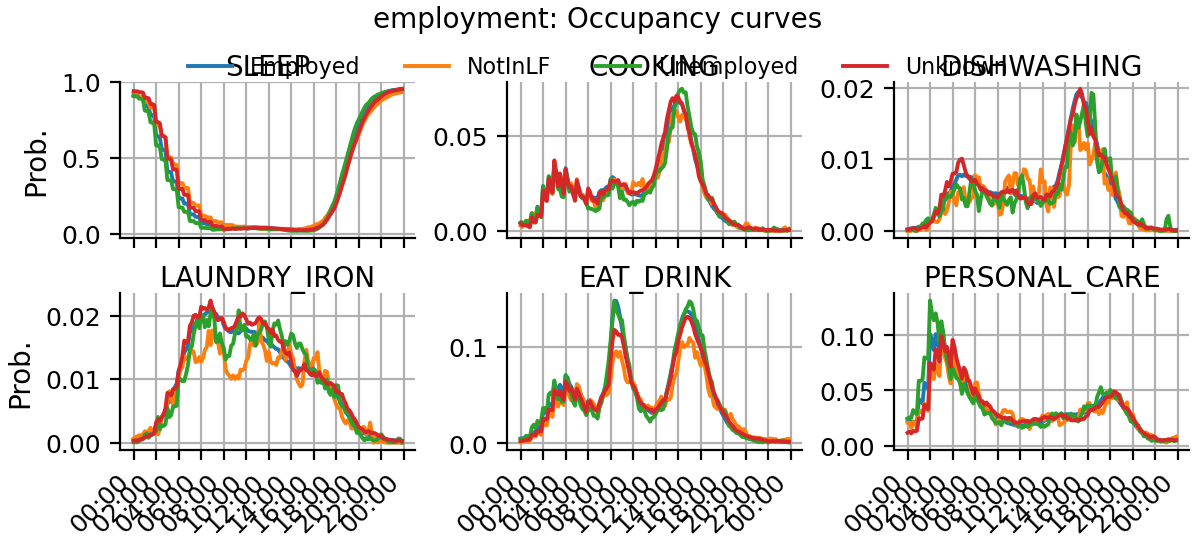

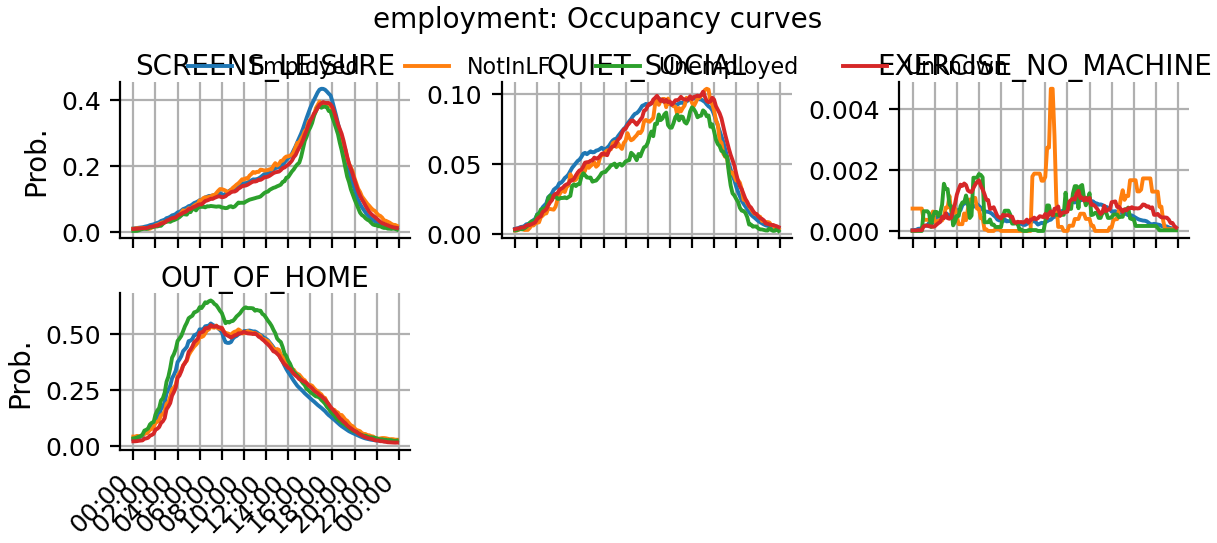

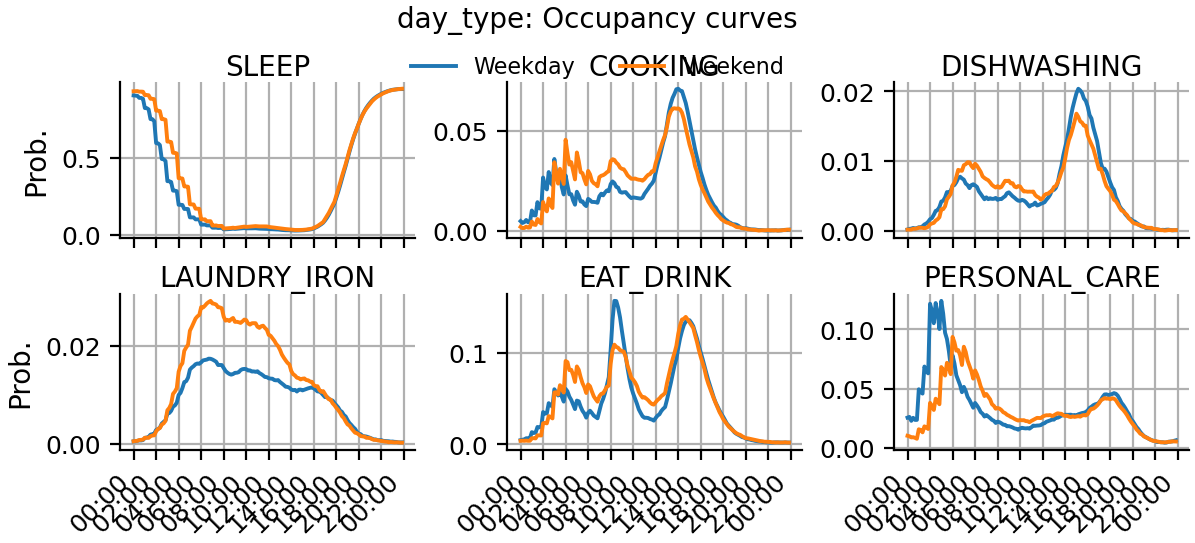

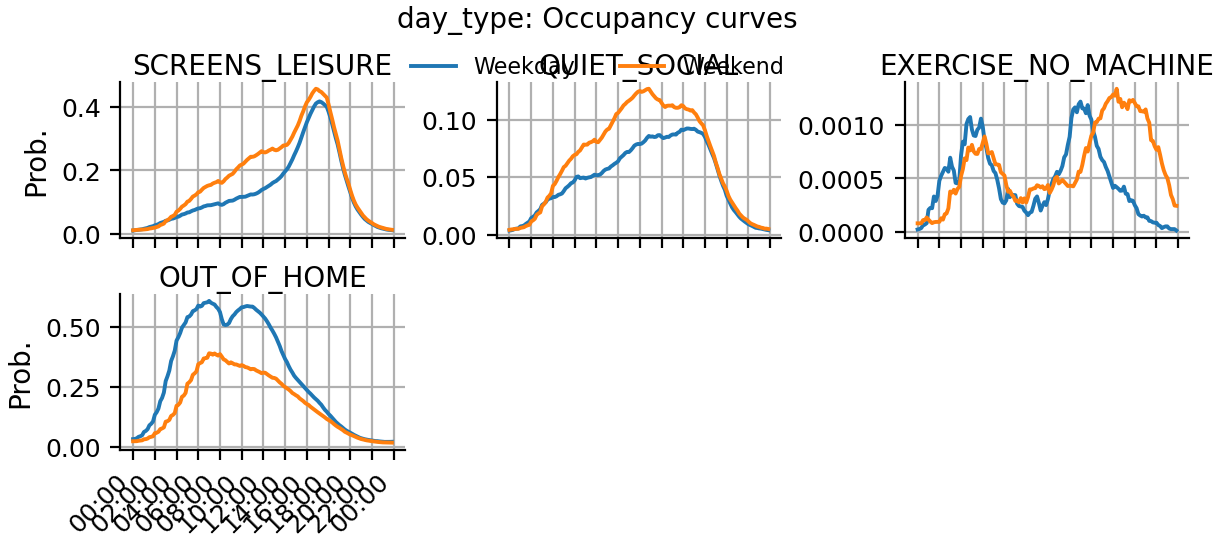

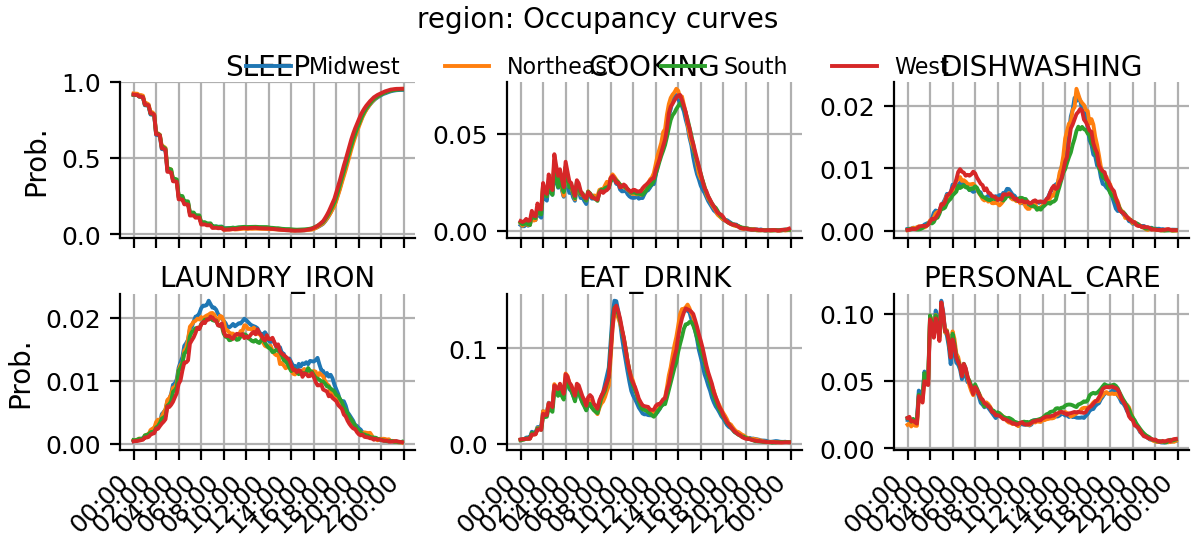

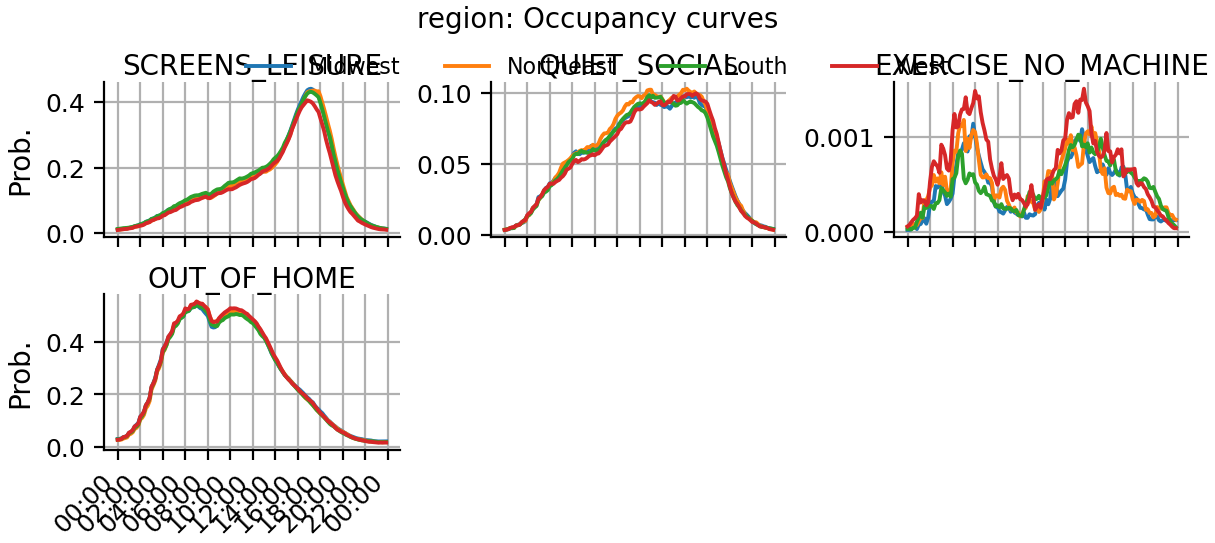

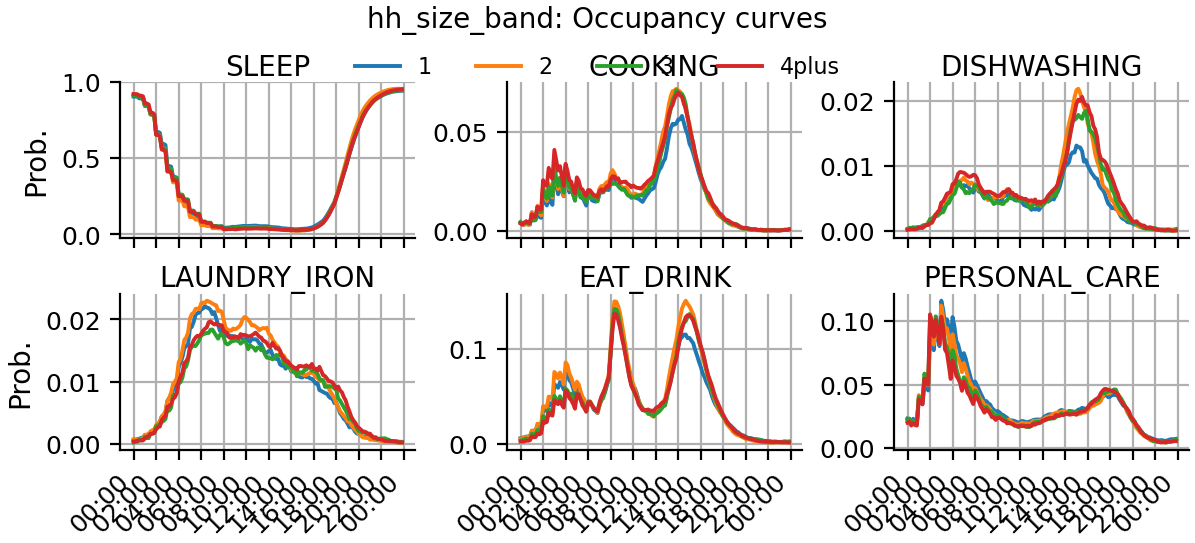

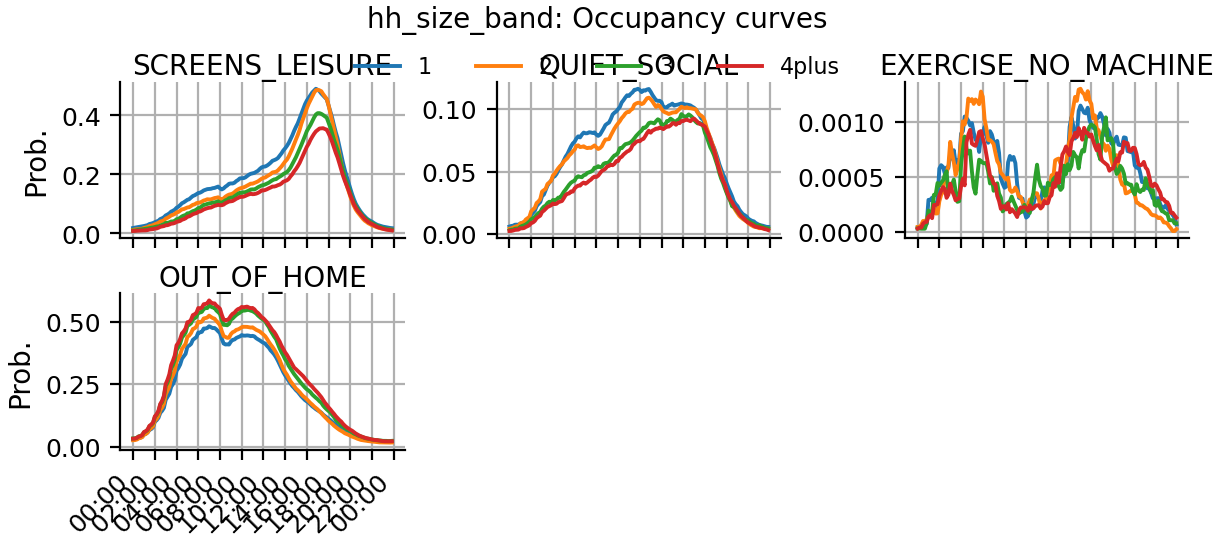

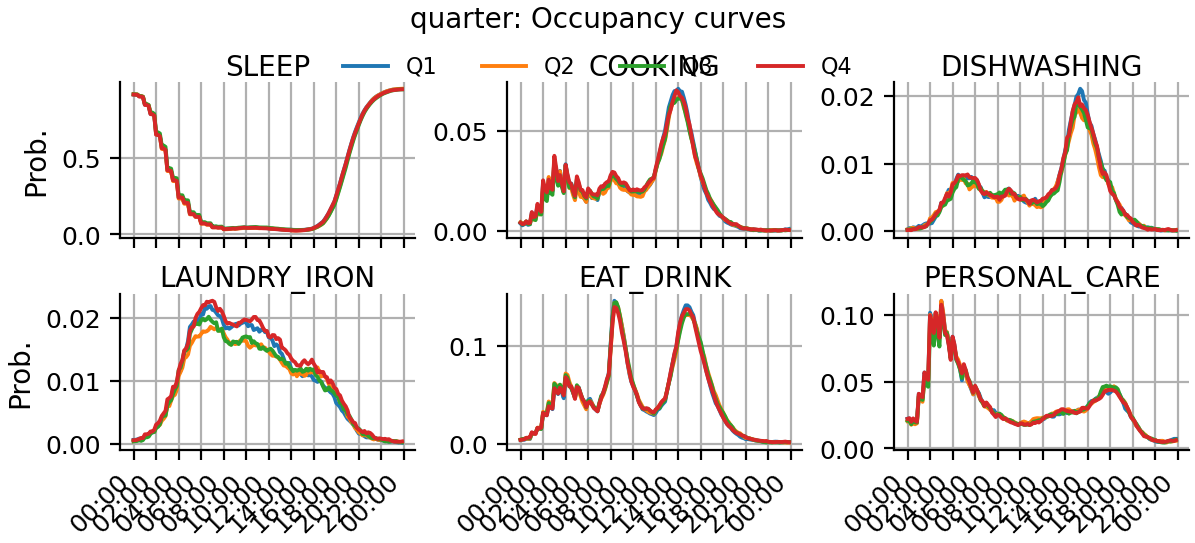

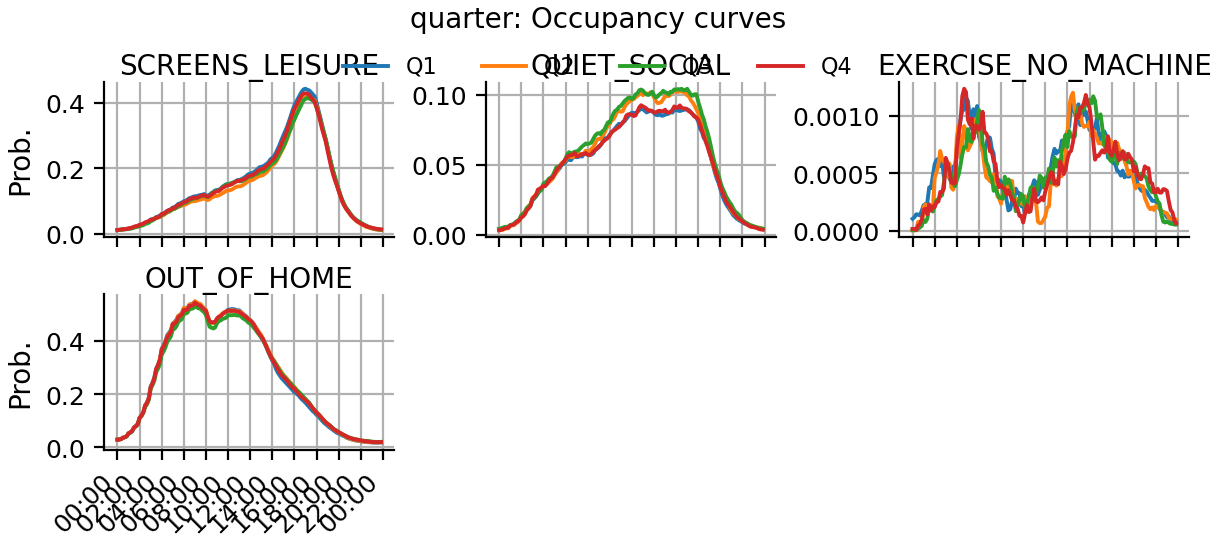

In [7]:
# === Cell 6: Grouped curves (compact) =======================================
def grouped_curves_compact(cov_name: str, cov: pd.Series, key_states: list[str] | None = None,
                           nrows=2, ncols=3, colwidth="one"):
    key_states = key_states or KEY_STATES
    levels = sorted([x for x in cov.dropna().unique().tolist()])
    if not levels:
        return

    # Precompute per-level occupancy once
    occs_by_level = {}
    for lv in levels:
        m = mask_eq(cov, lv)
        if m.any():
            occs_by_level[lv] = weighted_occupancy(states[m], w[m].to_numpy("float64"), K)

    per_page = nrows * ncols
    for page, chunk in enumerate(paginate(key_states, per_page), start=1):
        fig, axs = make_grid(nrows, ncols, colwidth=colwidth, h_per_row=1.25, sharex=True, sharey=False)
        for idx, s in enumerate(chunk):
            sid = sub_to_id.get(s, None)
            if sid is None: 
                continue
            ax = axs[idx // ncols, idx % ncols]
            for lv in levels:
                occ_lv = occs_by_level.get(lv, None)
                if occ_lv is None:
                    continue
                ax.plot(minutes, occ_lv[sid], label=str(lv))
            ax.set_title(s, pad=2)
            if idx // ncols == nrows - 1:
                xt, xl = hour_ticks(minutes)
                ax.set_xticks(xt); ax.set_xticklabels(xl, rotation=45, ha="right")
            else:
                ax.set_xticklabels([])
            if idx % ncols == 0:
                ax.set_ylabel("Prob.")
        hide_unused(axs)
        # single legend above
        handles, labs = axs[0,0].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labs, loc="upper center", ncol=min(len(labs), 4), frameon=False, bbox_to_anchor=(0.5, 1.02))
        fig.suptitle(f"{cov_name}: Occupancy curves", y=1.08, fontsize=10)
        fn = OUT_DIR / f"occ_{cov_name}_grid_p{page}.png"
        fig.savefig(fn, dpi=300)
        plt.show()

for cov_name, cov in [
    ("sex", sex),
    ("employment", employment),
    ("day_type", day_type),
    ("region", region),
    ("hh_size_band", hh_size),
    ("quarter", quarter),
]:
    grouped_curves_compact(cov_name, cov, KEY_STATES, nrows=2, ncols=3, colwidth="one")


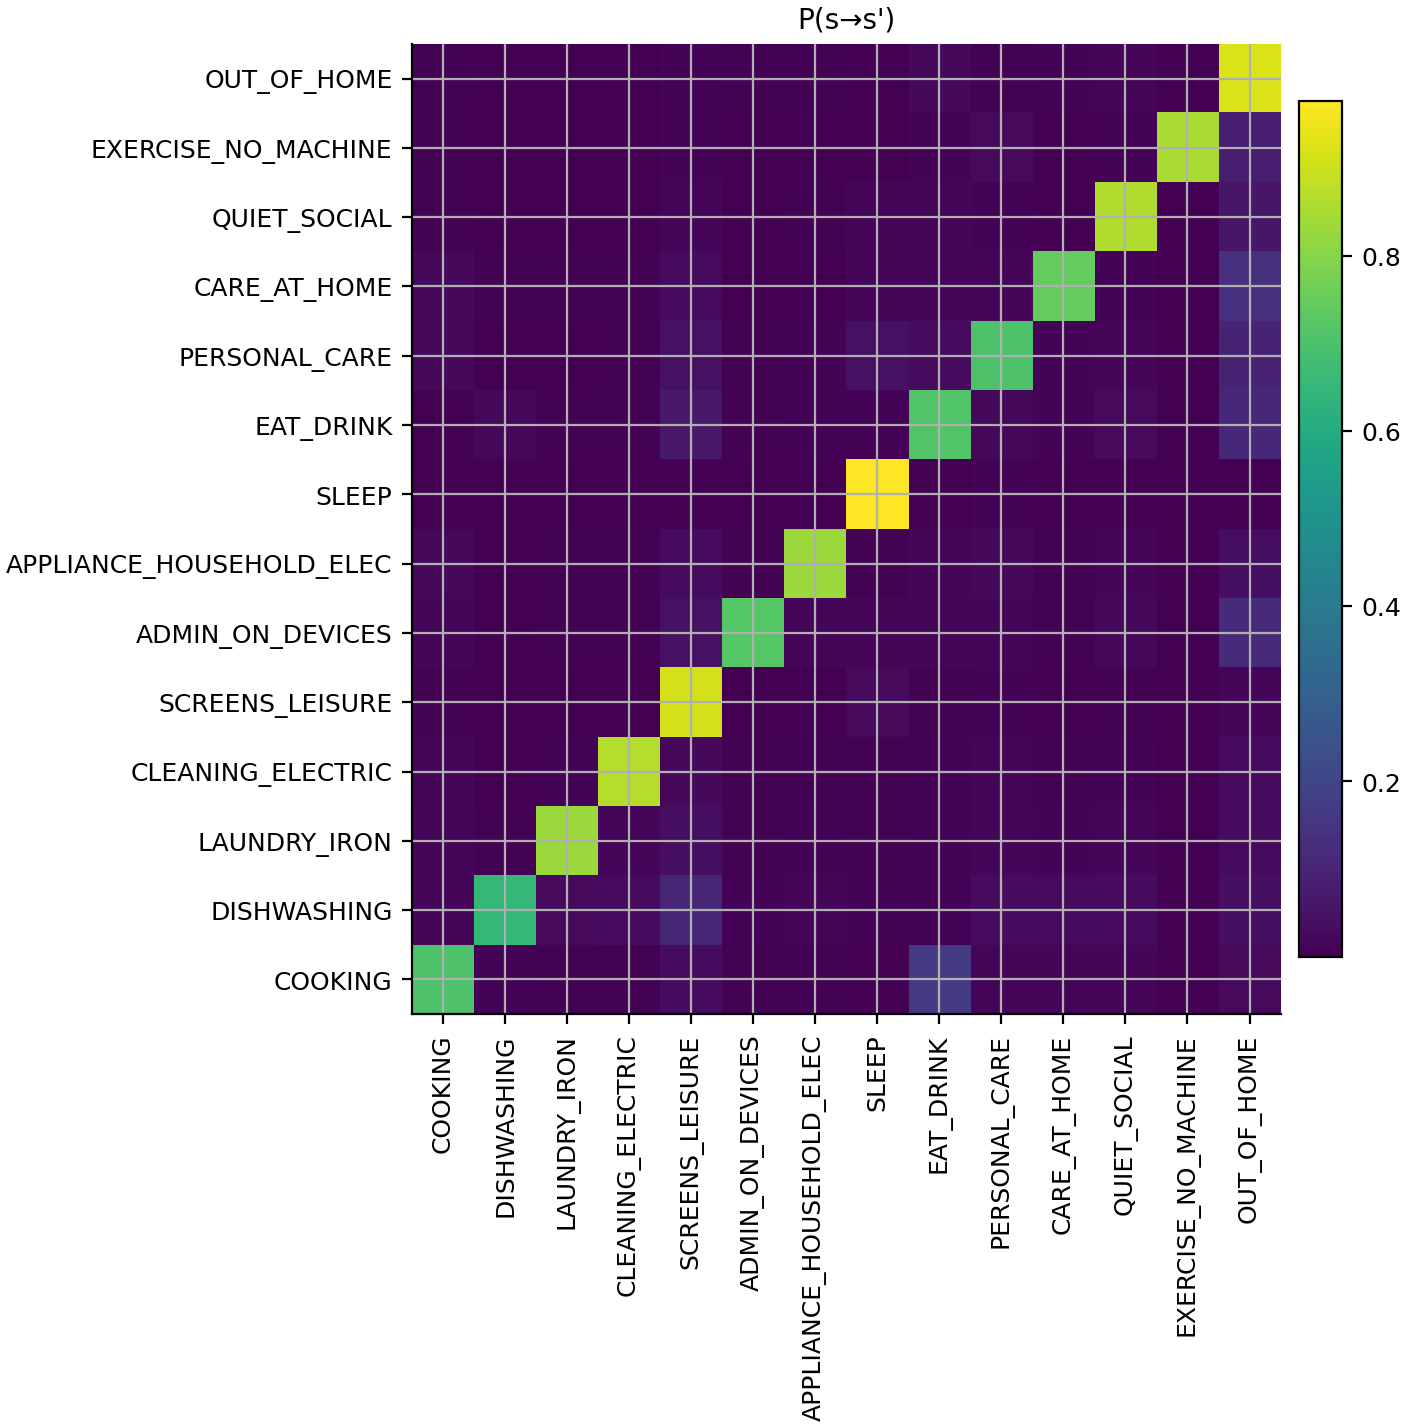

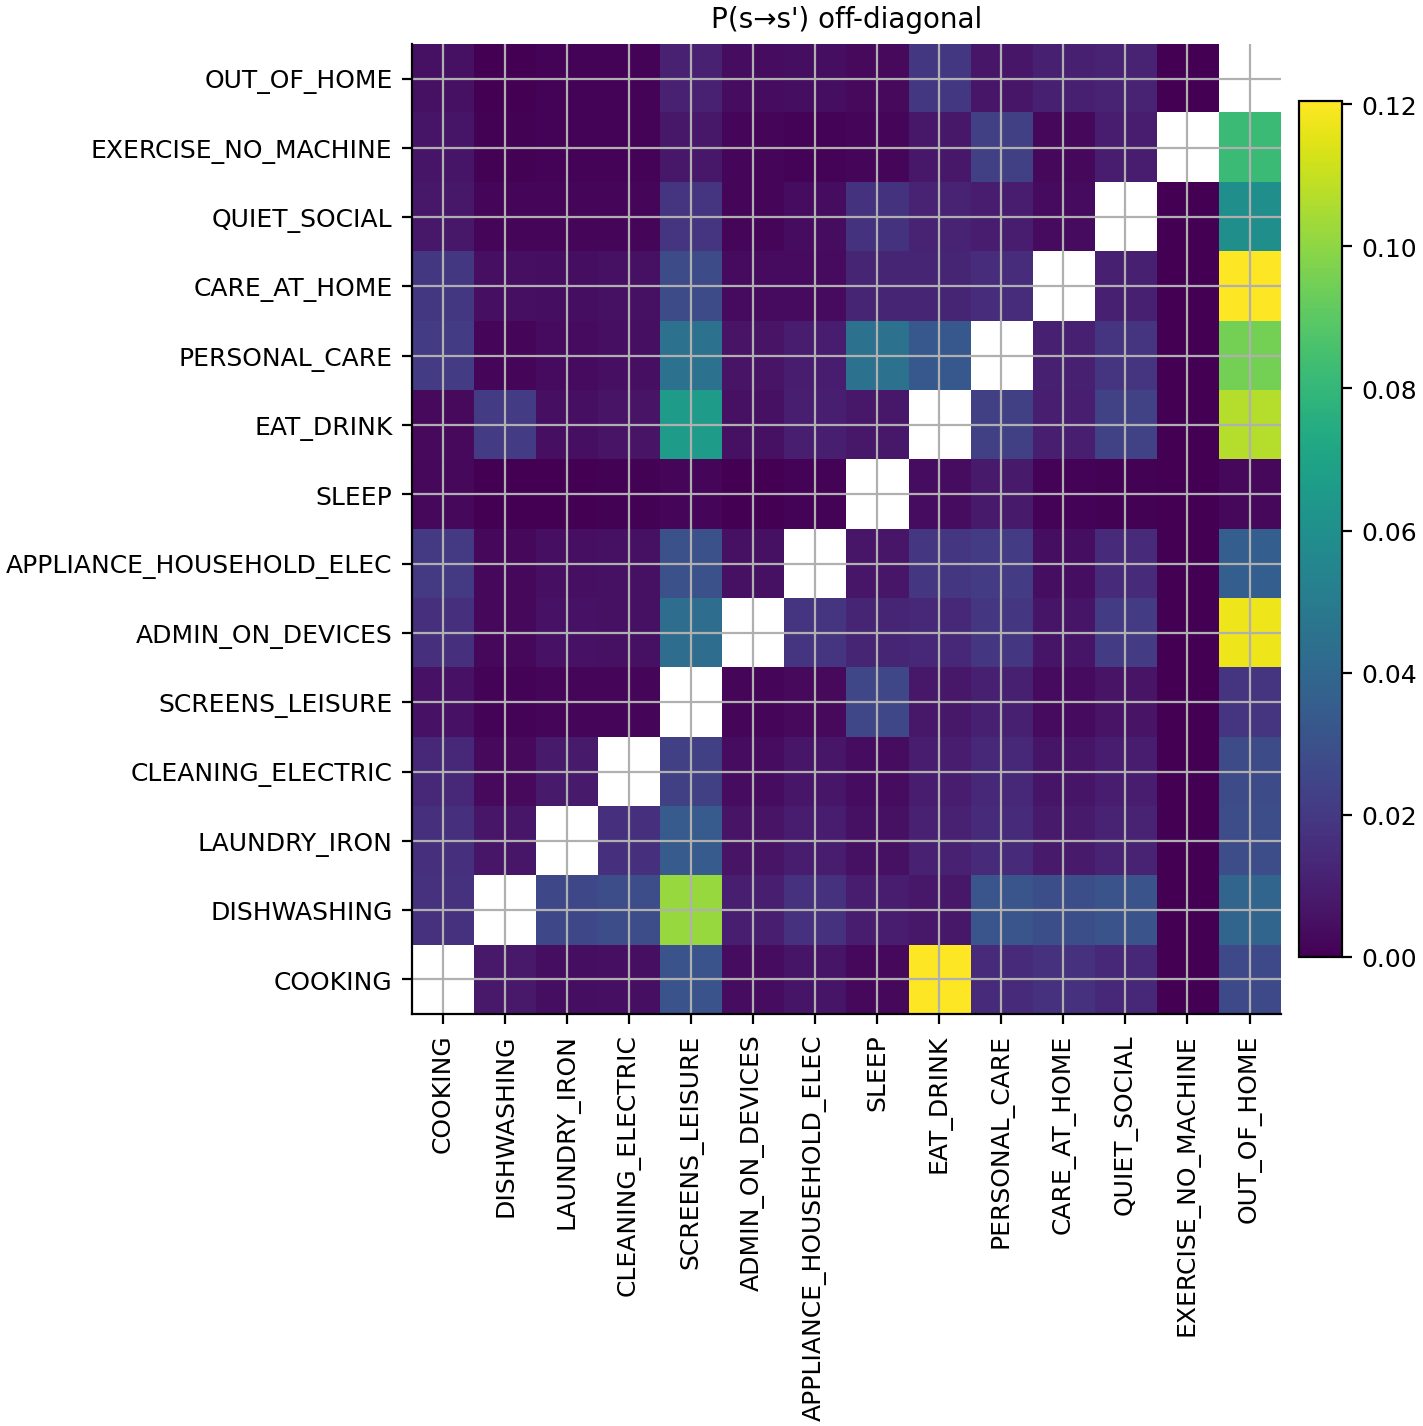

In [8]:
# === Cell 7: Transition matrices (exclude dummy state 0 everywhere) ==========
DUMMY_ID = 0

# Build full counts/probs while excluding any transition that touches the dummy state
C_full, R_full = weighted_transition_matrix(states, w.to_numpy("float64"), K, exclude_id=DUMMY_ID)

# Drop the dummy state's row/col
keep_ids = [i for i in range(K) if i != DUMMY_ID]
keep_mask = np.zeros(K, dtype=bool)
keep_mask[keep_ids] = True

C = C_full[keep_mask][:, keep_mask].copy()

# Re-normalize probabilities on the reduced set (safer than slicing R_full)
row_sums = C.sum(axis=1, keepdims=True)
R = np.divide(C, row_sums, where=row_sums > 0)

labels = np.array([label_for(i) for i in keep_ids])

def small_transition_heatmaps(R, labels, prefix="transition_probs_no0"):
    step = max(1, int(len(labels)//8))

    # Full
    fig, ax = plt.subplots(figsize=(INCH_COL1, INCH_COL1*1.05))
    im = ax.imshow(R, origin="lower", aspect="auto")
    ax.set_title("P(s→s')")
    ax.set_xticks(np.arange(0, len(labels), step)); ax.set_xticklabels(labels[::step], rotation=90)
    ax.set_yticks(np.arange(0, len(labels), step)); ax.set_yticklabels(labels[::step])
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
    fig.savefig(OUT_DIR / f"{prefix}_small.png", dpi=300)
    plt.show()

    # Off-diagonal focus
    R_off = R.copy()
    np.fill_diagonal(R_off, np.nan)
    vmax = np.nanpercentile(R_off, 99) if np.isfinite(R_off).any() else 1.0
    fig, ax = plt.subplots(figsize=(INCH_COL1, INCH_COL1*1.05))
    im = ax.imshow(R_off, origin="lower", aspect="auto", vmin=0, vmax=vmax)
    ax.set_title("P(s→s') off-diagonal")
    ax.set_xticks(np.arange(0, len(labels), step)); ax.set_xticklabels(labels[::step], rotation=90)
    ax.set_yticks(np.arange(0, len(labels), step)); ax.set_yticklabels(labels[::step])
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
    fig.savefig(OUT_DIR / f"{prefix}_offdiag_small.png", dpi=300)
    plt.show()

small_transition_heatmaps(R, labels)

# Save CSVs with dummy state removed
pd.DataFrame(C, index=labels, columns=labels).to_csv(TAB_DIR / "transition_counts_weighted_no0.csv")
pd.DataFrame(R, index=labels, columns=labels).to_csv(TAB_DIR / "transition_probs_weighted_no0.csv")


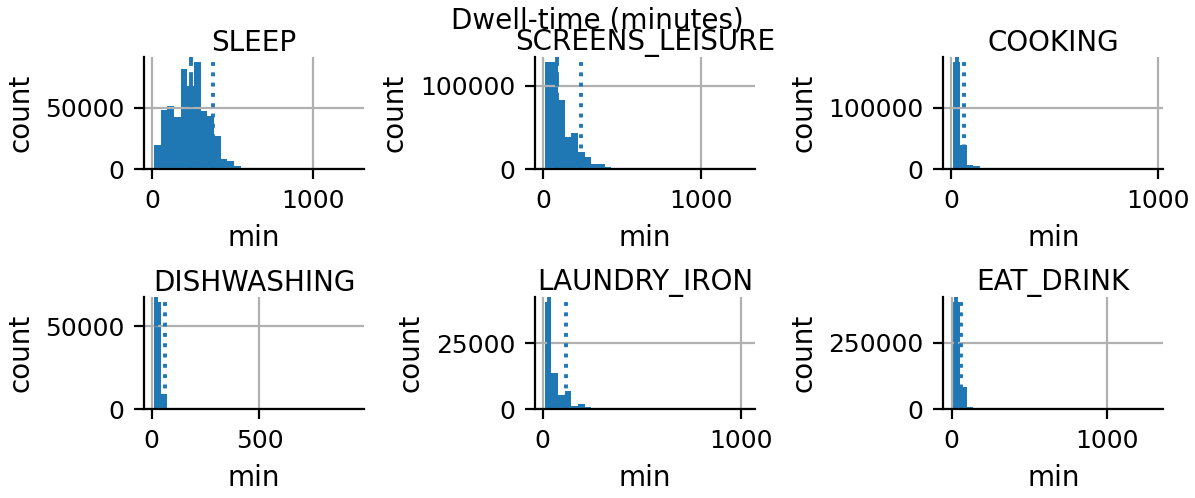

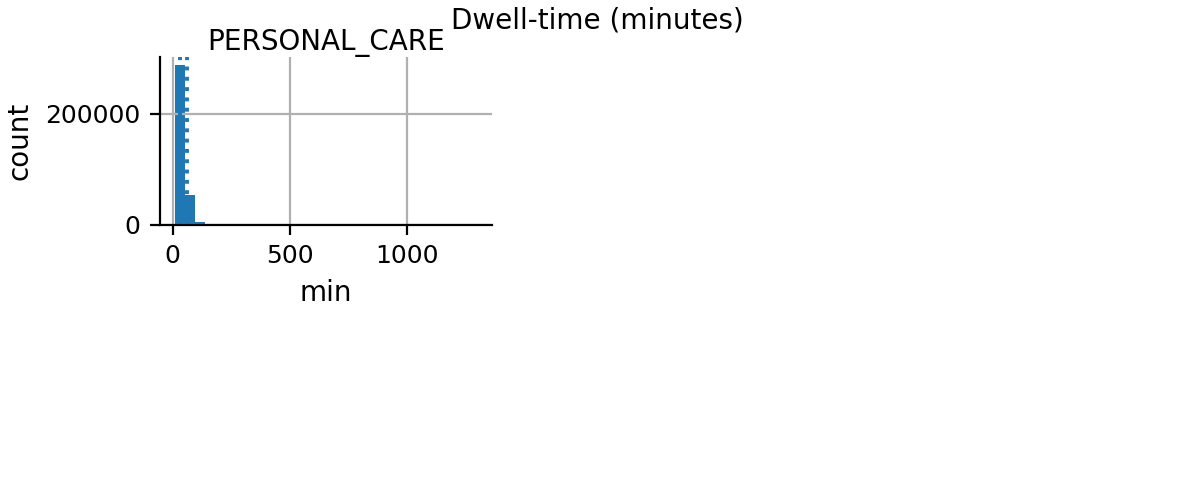

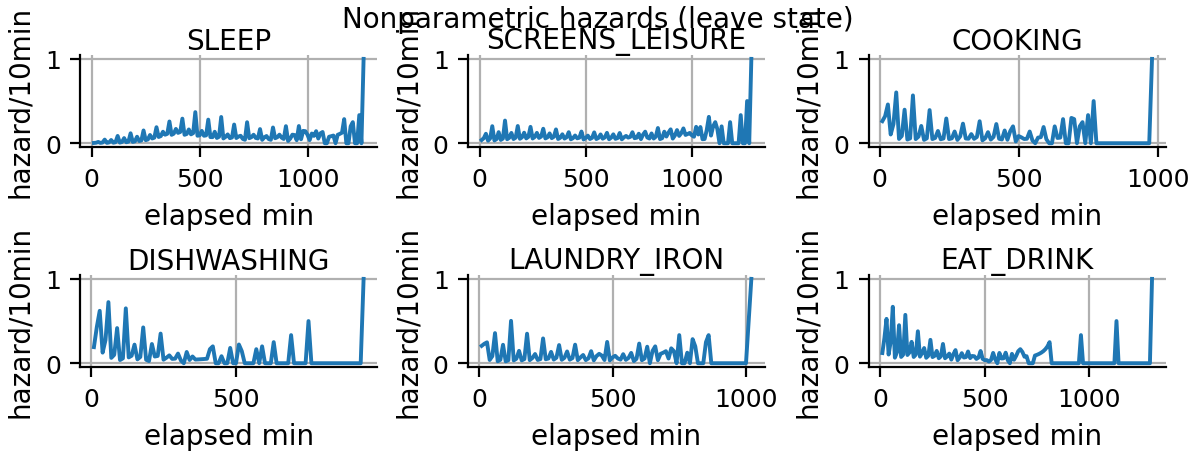

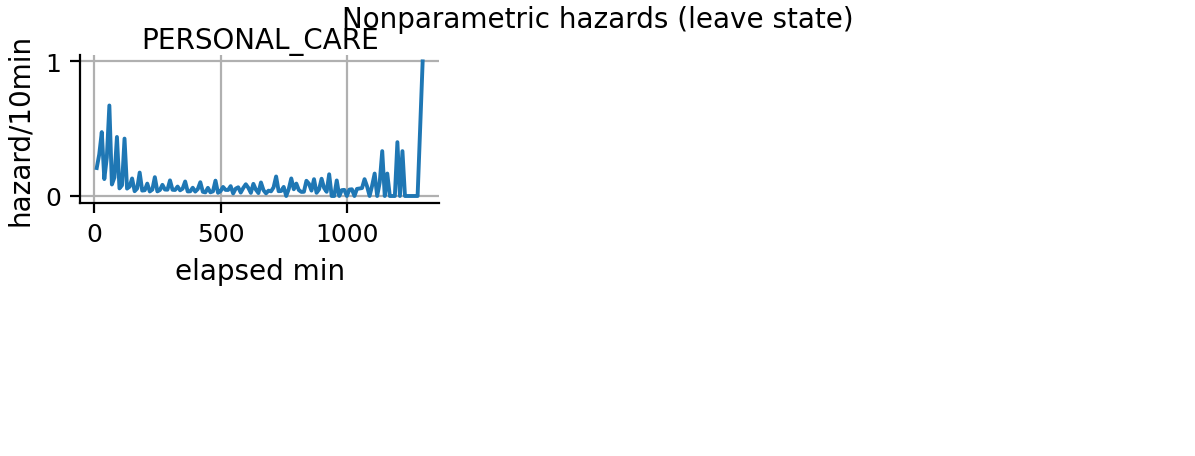

In [9]:
# === Cell 8: Dwell-time & hazard (compact) ===================================
def dwell_hazard_compact(states_list: list[str], nrows=2, ncols=3, colwidth="one"):
    per_page = nrows * ncols

    # Dwell histograms
    for page, chunk in enumerate(paginate(states_list, per_page), start=1):
        fig, axs = make_grid(nrows, ncols, colwidth=colwidth, h_per_row=1.2, sharex=False, sharey=False)
        for idx, name in enumerate(chunk):
            if name not in sub_to_id: 
                continue
            sid = sub_to_id[name]
            runs = dwell_time_runs(states, sid)
            if not runs: 
                continue
            durations_min = np.array(runs) * 10
            p50, p90 = np.percentile(durations_min, [50, 90])
            ax = axs[idx // ncols, idx % ncols]
            ax.hist(durations_min, bins=30)
            ax.axvline(p50, ls="--"); ax.axvline(p90, ls=":")
            ax.set_title(name, pad=1)
            ax.set_xlabel("min"); ax.set_ylabel("count")
        hide_unused(axs)
        fig.suptitle("Dwell-time (minutes)", y=1.03, fontsize=10)
        fig.savefig(OUT_DIR / f"dwell_grid_p{page}.png", dpi=300)
        plt.show()

    # Hazards
    for page, chunk in enumerate(paginate(states_list, per_page), start=1):
        fig, axs = make_grid(nrows, ncols, colwidth=colwidth, h_per_row=1.1, sharex=False, sharey=False)
        for idx, name in enumerate(chunk):
            if name not in sub_to_id: 
                continue
            sid = sub_to_id[name]
            runs = dwell_time_runs(states, sid)
            if not runs:
                continue
            haz = nonparametric_hazard_from_runs(runs)
            ax = axs[idx // ncols, idx % ncols]
            ax.plot(haz["t_min"], haz["hazard"])
            ax.set_title(name, pad=1)
            ax.set_xlabel("elapsed min"); ax.set_ylabel("hazard/10min")
        hide_unused(axs)
        fig.suptitle("Nonparametric hazards (leave state)", y=1.03, fontsize=10)
        fig.savefig(OUT_DIR / f"hazard_grid_p{page}.png", dpi=300)
        plt.show()

DWELL_STATES = [s for s in ["SLEEP","SCREENS_LEISURE","COOKING","DISHWASHING","LAUNDRY_IRON","EAT_DRINK","PERSONAL_CARE"] if s in sub_to_id]
dwell_hazard_compact(DWELL_STATES, nrows=2, ncols=3, colwidth="one")


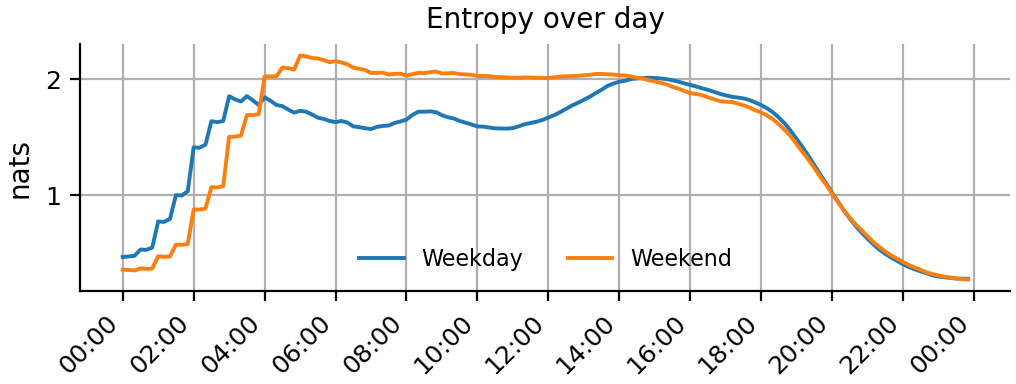

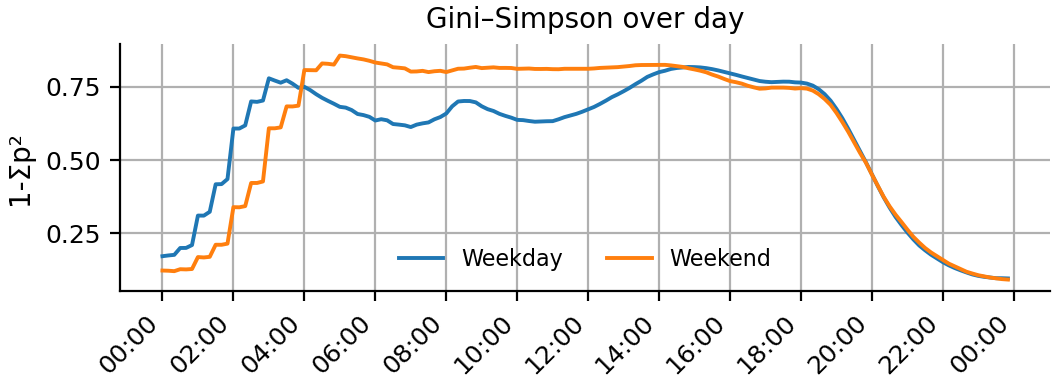

In [10]:
# === Cell 9: Variety curves (compact overlays) ===============================
def slot_entropy(occ: np.ndarray) -> np.ndarray:
    with np.errstate(divide="ignore", invalid="ignore"):
        logp = np.where(occ > 0, np.log(occ), 0.0)
    return -np.sum(occ * logp, axis=0)

def slot_gini_simpson(occ: np.ndarray) -> np.ndarray:
    return 1.0 - np.sum(occ*occ, axis=0)

def variety_compact(occ_dict: dict[str, np.ndarray], prefix: str, colwidth="one"):
    # Entropy
    fig, ax = plt.subplots(figsize=(INCH_COL1, 1.6))
    for name, occ in occ_dict.items():
        ax.plot(minutes, slot_entropy(occ), label=name)
    xt, xl = hour_ticks(minutes)
    ax.set_xticks(xt); ax.set_xticklabels(xl, rotation=45, ha="right")
    ax.set_ylabel("nats"); ax.set_title("Entropy over day")
    ax.legend(ncol=min(4, len(occ_dict)), frameon=False)
    fig.savefig(OUT_DIR / f"{prefix}_entropy_small.png", dpi=300)
    plt.show()
    # Gini–Simpson
    fig, ax = plt.subplots(figsize=(INCH_COL1, 1.6))
    for name, occ in occ_dict.items():
        ax.plot(minutes, slot_gini_simpson(occ), label=name)
    ax.set_xticks(xt); ax.set_xticklabels(xl, rotation=45, ha="right")
    ax.set_ylabel("1-Σp²"); ax.set_title("Gini–Simpson over day")
    ax.legend(ncol=min(4, len(occ_dict)), frameon=False)
    fig.savefig(OUT_DIR / f"{prefix}_gini_small.png", dpi=300)
    plt.show()

# Example: by day_type
occ_by_daytype = {}
for lv in sorted([x for x in day_type.dropna().unique().tolist()]):
    m = mask_eq(day_type, lv)
    if m.any():
        occ_by_daytype[str(lv)] = weighted_occupancy(states[m], w[m].to_numpy("float64"), K)
if occ_by_daytype:
    variety_compact(occ_by_daytype, prefix="variety_day_type", colwidth="one")


In [11]:
# === Cell 10: RUNG_SPECS and single-covariate selection =====================
RUNG_SPECS = {
    "R1":  "region",
    "R2":  "region,sex", 
    "R3":  "region,employment",
    "R4":  "region,day_type",
    "R5":  "region,hh_size_band",
    "R6":  "region, quarter",
    "R7":  "employment,day_type,hh_size_band,sex,region,quarter",  # + hazard
    "R8":  "sex",
    "R9":  "employment",
    "R10": "day_type",
    "R11": "hh_size_band",
    "R12": "quarter",
}

def _parse_covs(spec: str) -> list[str]:
    return [x.strip() for x in spec.split(",") if x.strip()]

SINGLE_COV_RUNGS = {r: _parse_covs(s) for r, s in RUNG_SPECS.items() if len(_parse_covs(s)) == 1}
SINGLE_COVS = sorted({cov for covs in SINGLE_COV_RUNGS.values() for cov in covs})
print("Single-covariate rungs:", SINGLE_COV_RUNGS)
print("Single covariates to analyze:", SINGLE_COVS)


Single-covariate rungs: {'R1': ['region'], 'R8': ['sex'], 'R9': ['employment'], 'R10': ['day_type'], 'R11': ['hh_size_band'], 'R12': ['quarter']}
Single covariates to analyze: ['day_type', 'employment', 'hh_size_band', 'quarter', 'region', 'sex']


In [12]:
# === Cell 11: Category-importance helpers ===================================
_EPS = 1e-12

def occ_by_level(cov: pd.Series, weights: pd.Series, states: np.ndarray, K: int) -> dict:
    out = {}
    levels = sorted([lv for lv in cov.dropna().unique().tolist()])
    for lv in levels:
        m = mask_eq(cov, lv)
        if not m.any():
            continue
        out[lv] = weighted_occupancy(states[m], weights[m].to_numpy("float64"), K)
    return out

def sym_kl_over_day(P: np.ndarray, Q: np.ndarray) -> float:
    P_ = np.clip(P, _EPS, 1.0)
    Q_ = np.clip(Q, _EPS, 1.0)
    kl_pq = np.sum(P_ * (np.log(P_) - np.log(Q_)))
    kl_qp = np.sum(Q_ * (np.log(Q_ - 0*_EPS) - np.log(P_)))  # stable symmetrical form
    return float(kl_pq + kl_qp)

def frob2(P: np.ndarray, Q: np.ndarray) -> float:
    D = P - Q
    return float(np.sum(D*D))

def level_weights(cov: pd.Series, weights: pd.Series) -> pd.Series:
    df = pd.DataFrame({"cov": cov, "w": weights}).dropna()
    g = df.groupby("cov", dropna=False)["w"].sum()
    share = g / g.sum() if g.sum() > 0 else g
    return share

def mutual_information_bits_timewise(cov: pd.Series, weights: pd.Series, states: np.ndarray, K: int) -> pd.DataFrame:
    levels = [lv for lv in cov.dropna().unique().tolist()]
    L = len(levels)
    if L == 0:
        return pd.DataFrame({"t": np.arange(states.shape[1]), "MI_bits": np.zeros(states.shape[1])})

    wshare = level_weights(cov, weights).to_dict()
    p_c = np.array([max(_EPS, wshare.get(lv, 0.0)) for lv in levels], dtype=float)
    p_c = p_c / p_c.sum()

    Tslots = states.shape[1]
    MI_bits = np.zeros(Tslots, dtype=float)
    level_to_mask = {lv: mask_eq(cov, lv) for lv in levels}

    for t in range(Tslots):
        # p(s|t)
        p_s = np.zeros(K, dtype=float)
        col = states[:, t]
        np.add.at(p_s, col, weights.to_numpy("float64"))
        denom = float(weights.sum())
        if denom > 0:
            p_s /= denom
        p_s = np.clip(p_s, _EPS, 1.0); p_s /= p_s.sum()

        # p(c,s)
        p_cs = np.zeros((L, K), dtype=float)
        for i, lv in enumerate(levels):
            m = level_to_mask[lv]
            if m.any():
                np.add.at(p_cs[i], states[m, t], weights[m].to_numpy("float64"))
        if denom > 0:
            p_cs /= denom
        p_cs = np.clip(p_cs, _EPS, 1.0)

        MI_nats = np.sum(p_cs * (np.log(p_cs) - (np.log(p_c)[:, None] + np.log(p_s)[None, :])))
        MI_bits[t] = MI_nats / np.log(2.0)

    return pd.DataFrame({"t": np.arange(Tslots), "MI_bits": MI_bits})


In [13]:
# OPTIONAL (before Cell 12):
if "region" not in SINGLE_COVS:
    SINGLE_COVS = ["region"] + SINGLE_COVS



=== Category importance: day_type ===


,covariate,level,weight_share,frob2_vs_overall,symKL_vs_overall_bits,importance_share_frob2_norm
1,day_type,Weekend,0.2858,2.749819,15.721538,0.861969
0,day_type,Weekday,0.7142,0.440340,2.363019,0.138031


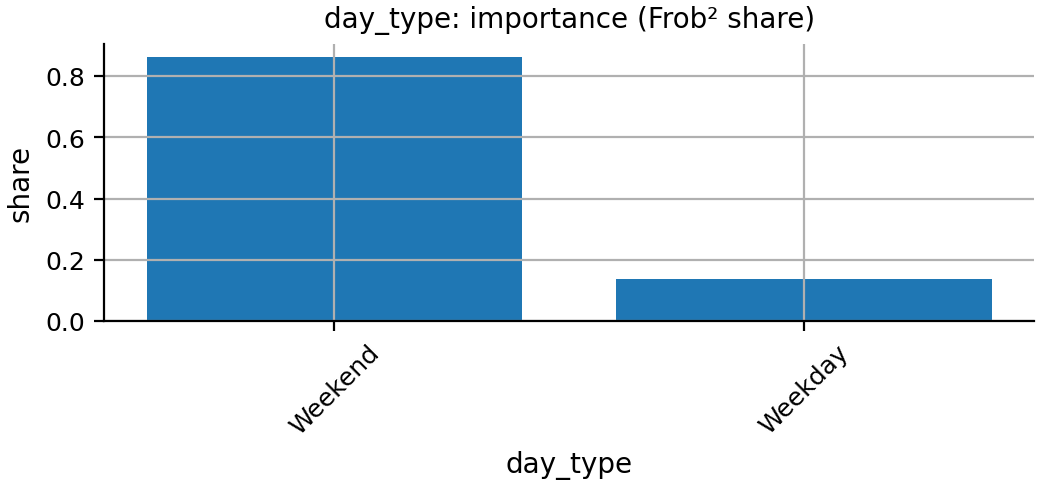

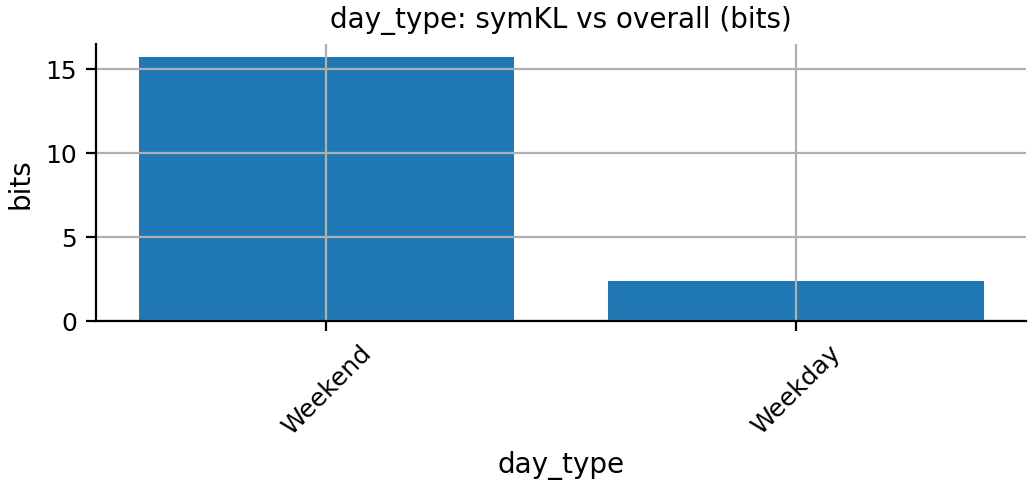

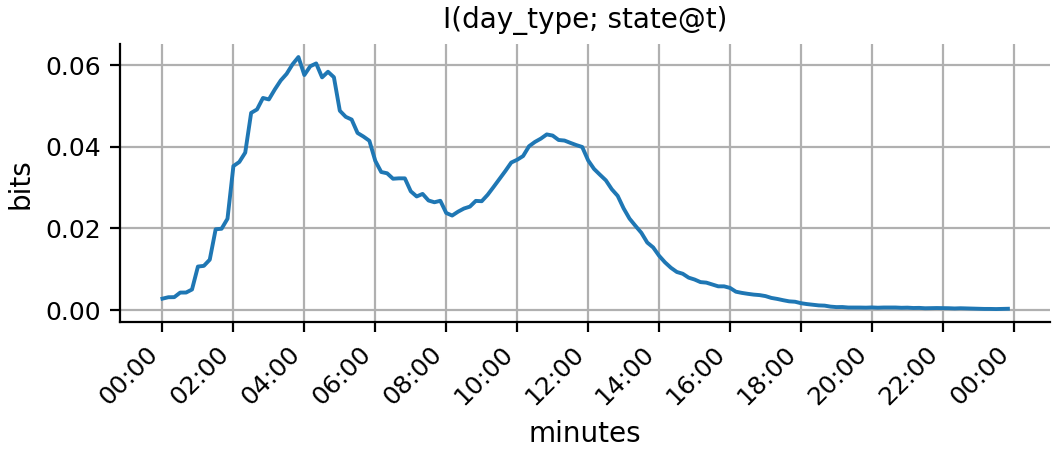

,covariate,MI_bits_mean,MI_bits_peak,t_peak_min
0,day_type,0.020871,0.061981,230



=== Category importance: employment ===


,covariate,level,weight_share,frob2_vs_overall,symKL_vs_overall_bits,importance_share_frob2_norm
2,employment,Unemployed,0.016771,1.017352,8.203667,0.542998
1,employment,NotInLF,0.016855,0.499676,6.182846,0.266695
3,employment,Unknown,0.130829,0.346755,2.684667,0.185076
0,employment,Employed,0.835545,0.009802,0.079680,0.005232


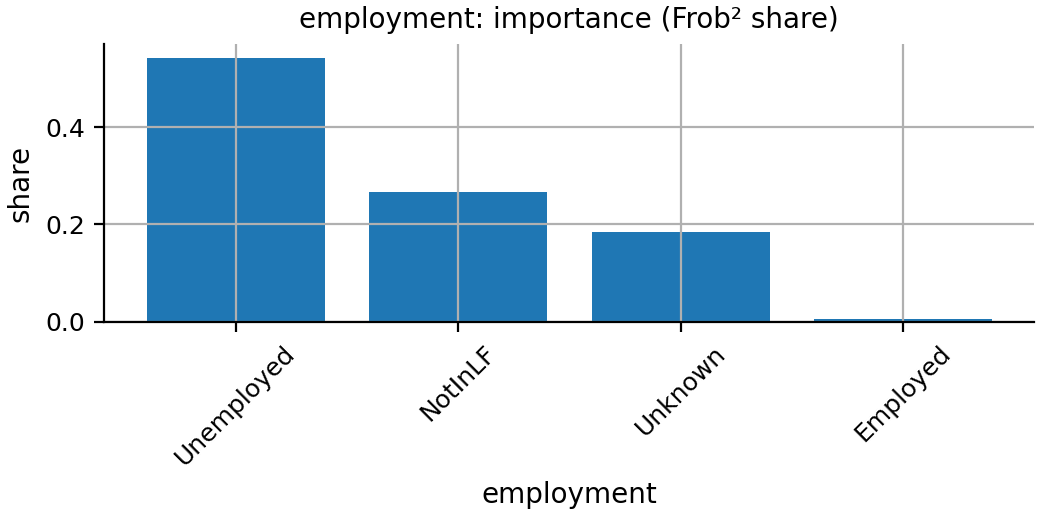

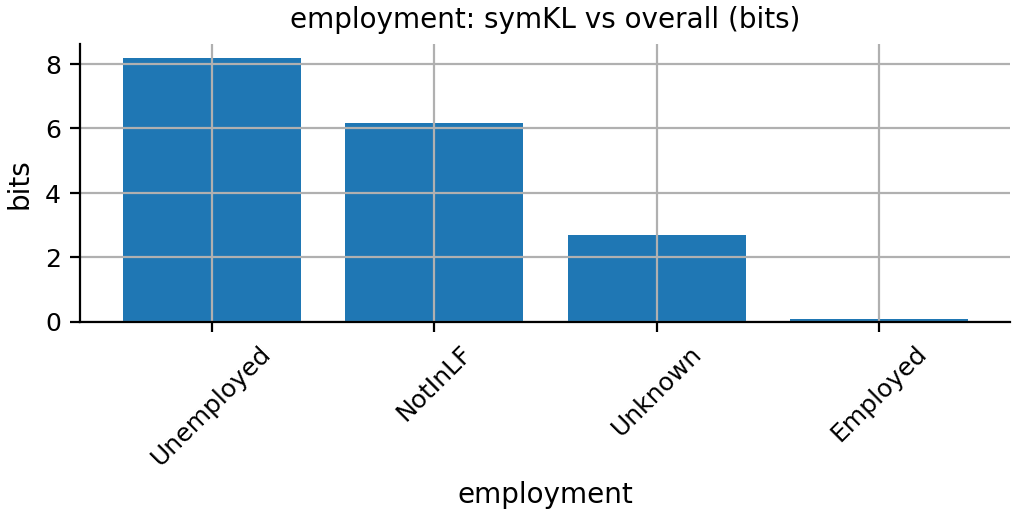

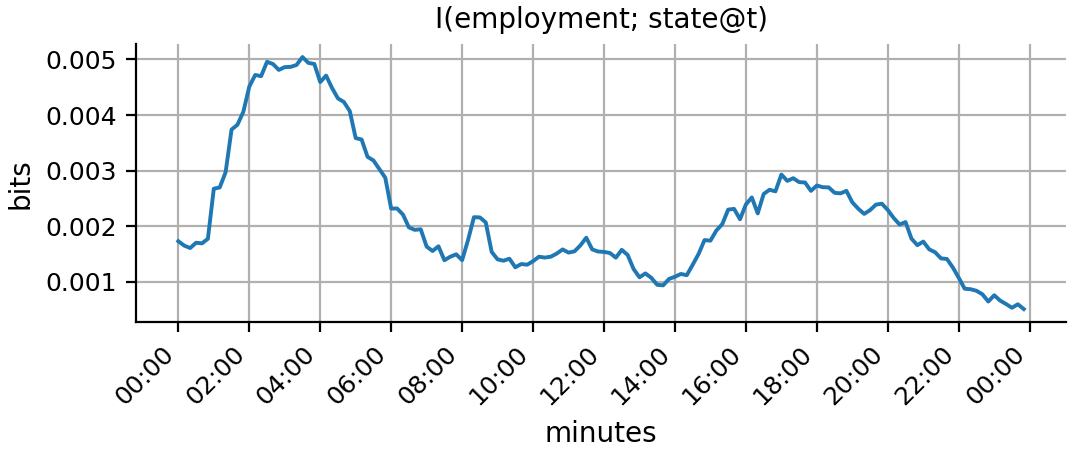

,covariate,MI_bits_mean,MI_bits_peak,t_peak_min
0,employment,0.002224,0.005044,210



=== Category importance: hh_size_band ===


,covariate,level,weight_share,frob2_vs_overall,symKL_vs_overall_bits,importance_share_frob2_norm
0,hh_size_band,1,0.148253,0.656090,9.820328,0.473248
3,hh_size_band,4plus,0.335929,0.404248,5.207350,0.291590
1,hh_size_band,2,0.329920,0.236706,4.562230,0.170739
2,hh_size_band,3,0.185898,0.089312,1.178018,0.064422


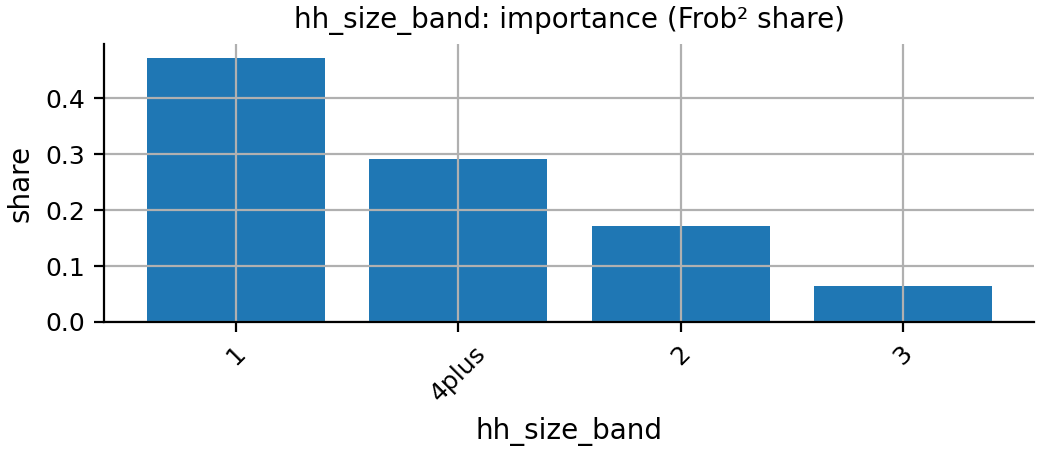

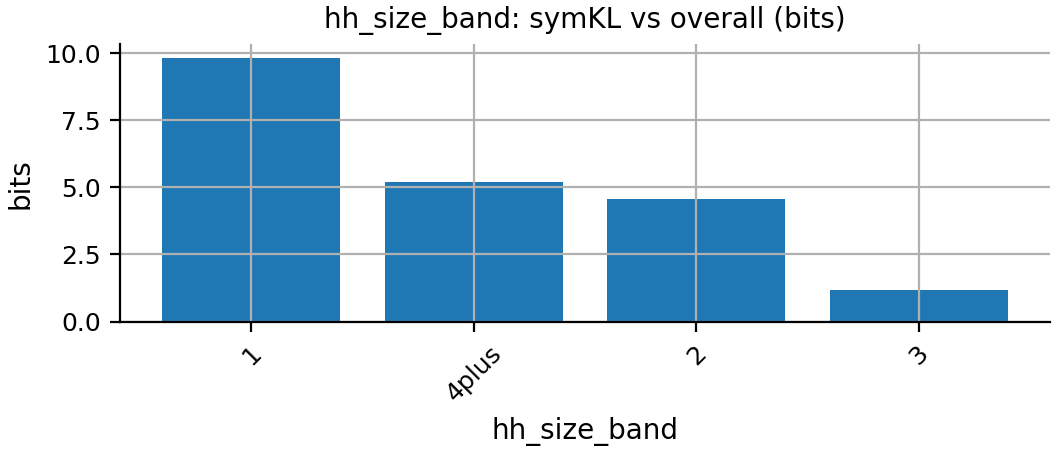

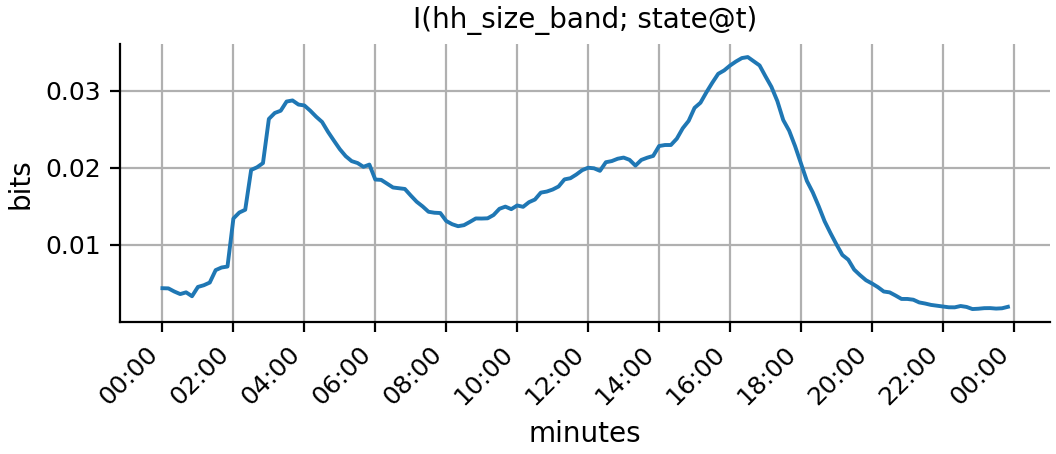

,covariate,MI_bits_mean,MI_bits_peak,t_peak_min
0,hh_size_band,0.016072,0.034342,990



=== Category importance: quarter ===


,covariate,level,weight_share,frob2_vs_overall,symKL_vs_overall_bits,importance_share_frob2_norm
2,quarter,Q3,0.252183,0.029608,0.335380,0.321432
0,quarter,Q1,0.246190,0.028675,0.537342,0.311305
1,quarter,Q2,0.248809,0.023933,0.456525,0.259826
3,quarter,Q4,0.252817,0.009896,0.241032,0.107436


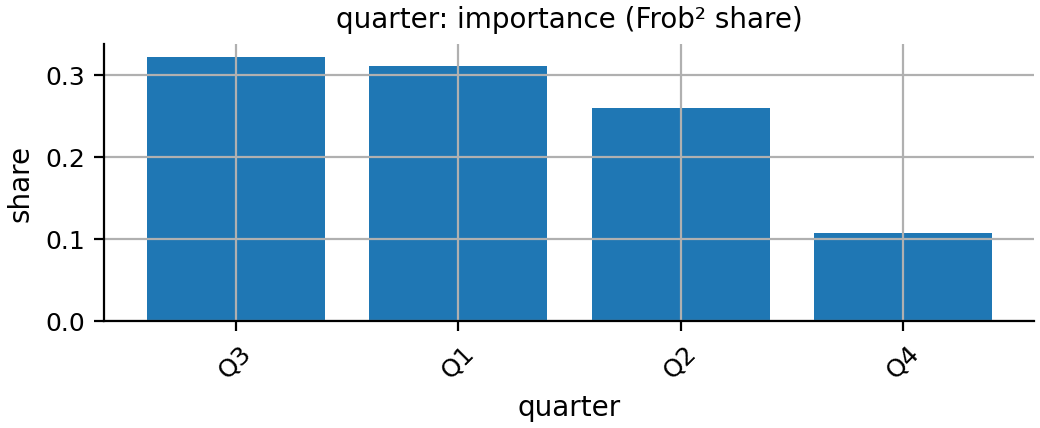

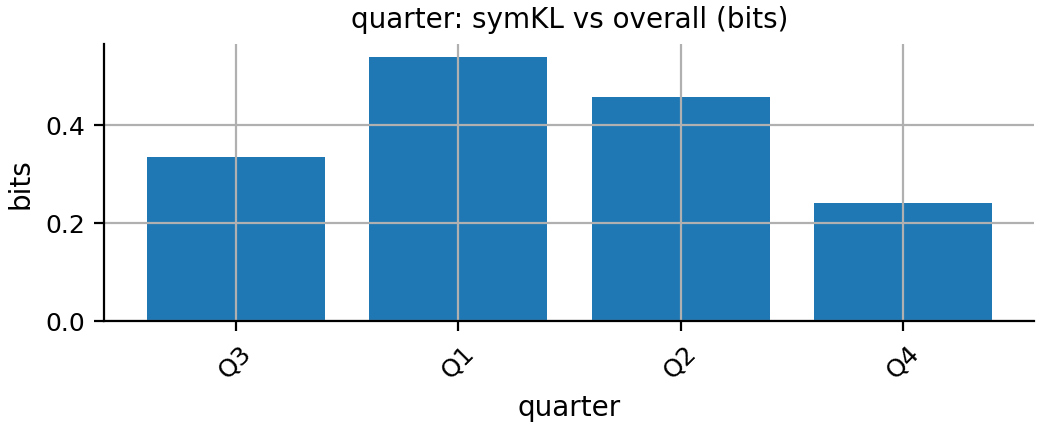

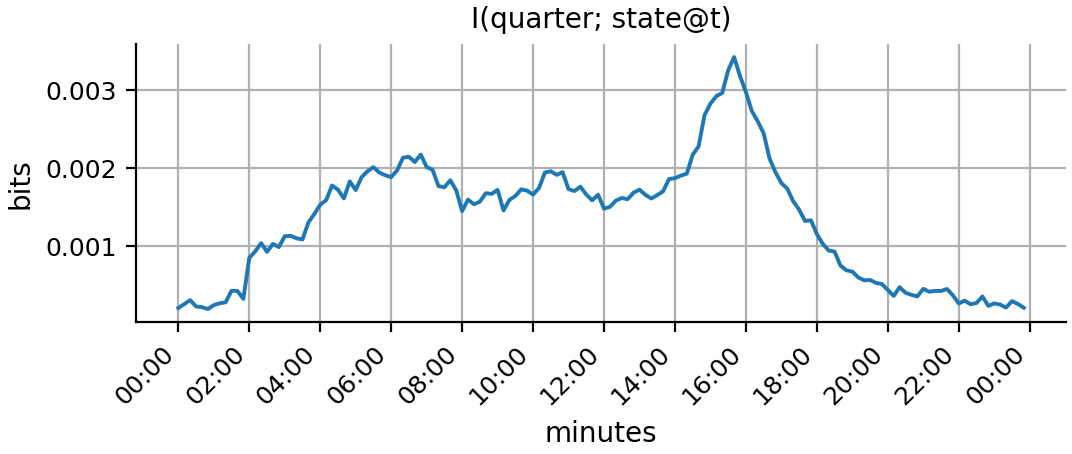

,covariate,MI_bits_mean,MI_bits_peak,t_peak_min
0,quarter,0.001351,0.003427,940



=== Category importance: region ===


,covariate,level,weight_share,frob2_vs_overall,symKL_vs_overall_bits,importance_share_frob2_norm
3,region,West,0.219746,0.066024,0.597468,0.499820
1,region,Northeast,0.176153,0.035270,0.444898,0.267004
0,region,Midwest,0.236584,0.017912,0.372352,0.135597
2,region,South,0.367517,0.012890,0.252743,0.097579


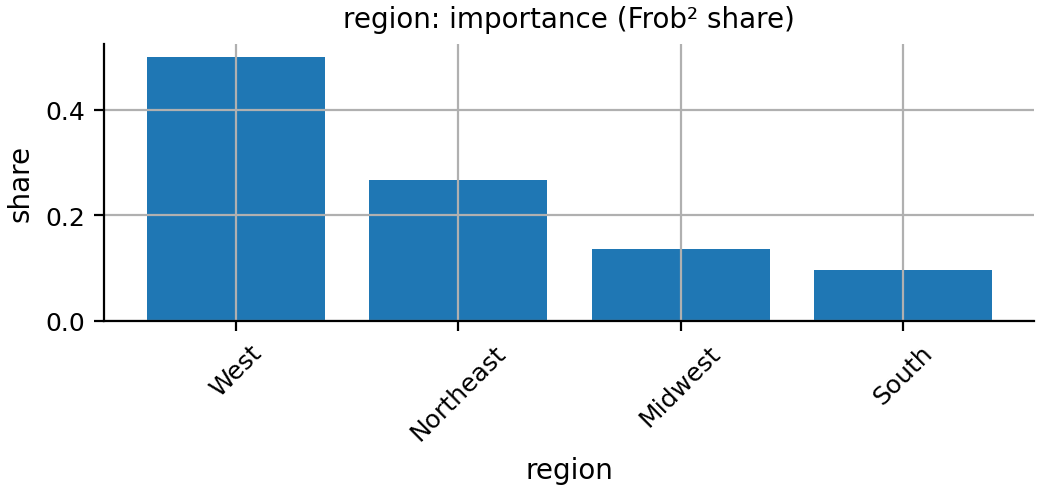

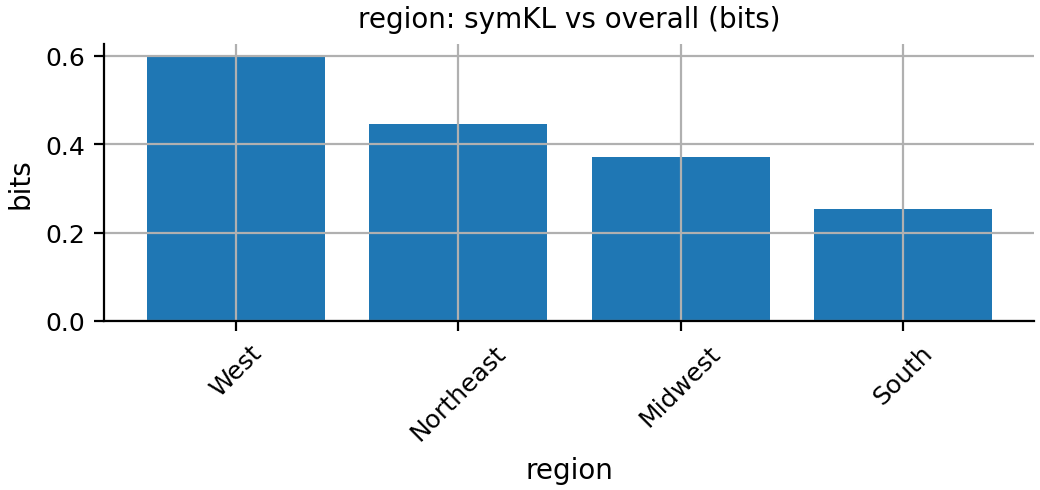

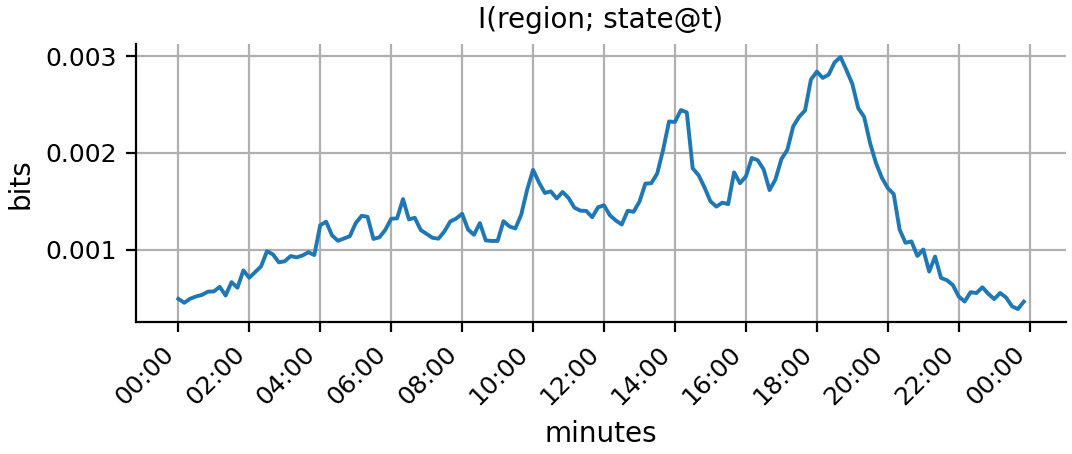

,covariate,MI_bits_mean,MI_bits_peak,t_peak_min
0,region,0.001353,0.002989,1120



=== Category importance: sex ===


,covariate,level,weight_share,frob2_vs_overall,symKL_vs_overall_bits,importance_share_frob2_norm
1,sex,Male,0.48465,0.226527,5.164447,0.530672
0,sex,Female,0.51535,0.200342,3.575605,0.469328


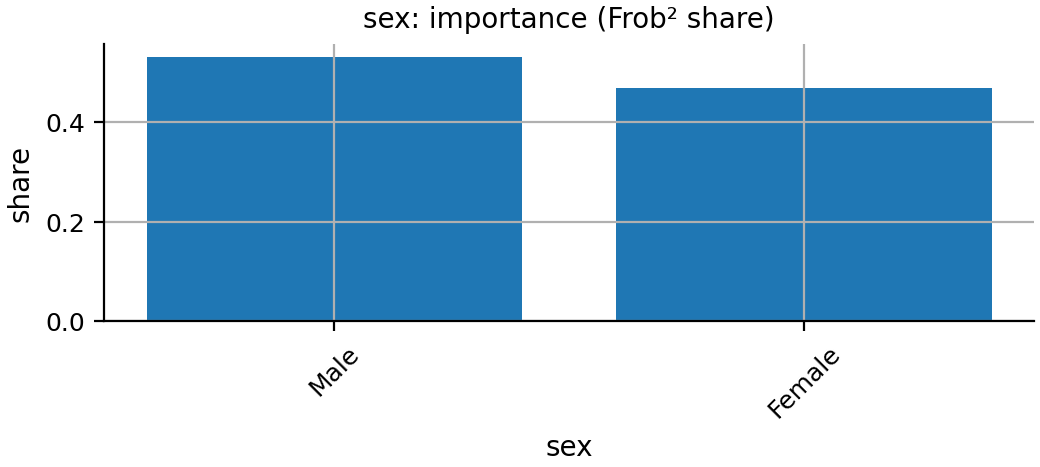

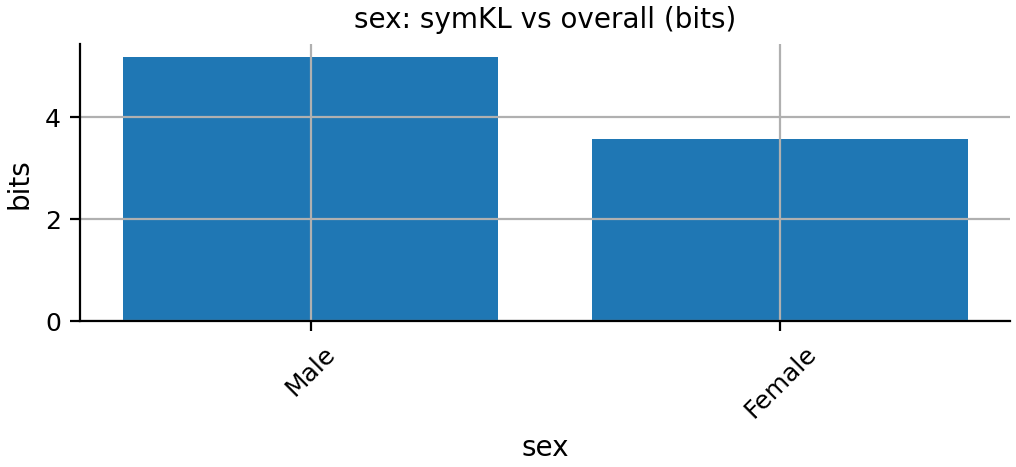

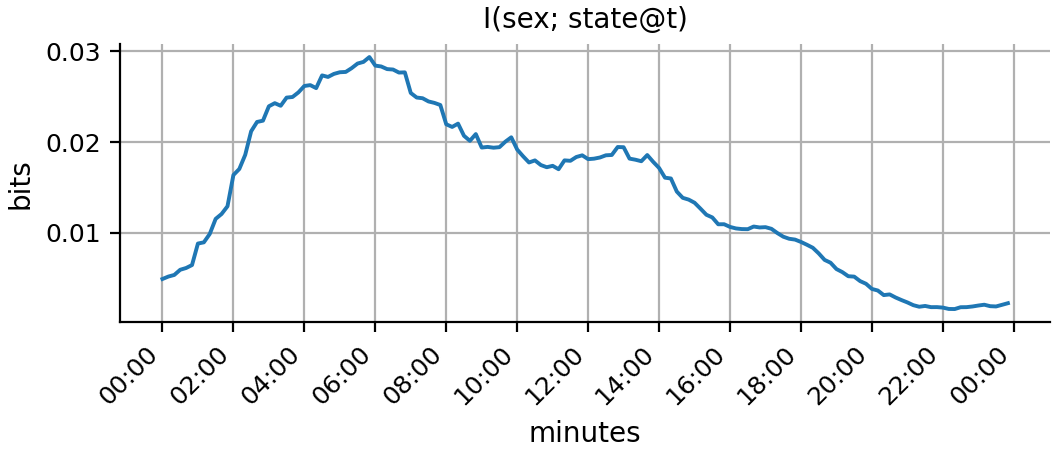

,covariate,MI_bits_mean,MI_bits_peak,t_peak_min
0,sex,0.014643,0.029351,350


In [14]:
# === Cell 12: Category importance per single covariate =======================
cov_map = {
    "region": region,
    "sex": sex,
    "employment": employment,
    "day_type": day_type,
    "hh_size_band": hh_size,
    "quarter": quarter,
}

def category_importance_for_cov(cov_name: str, cov_series: pd.Series):
    print(f"\n=== Category importance: {cov_name} ===")
    occ_overall = weighted_occupancy(states, w.to_numpy("float64"), K)
    occ_levels = occ_by_level(cov_series, w, states, K)
    shares = level_weights(cov_series, w)

    rows = []
    f2_total = 0.0
    for lv, occ_lv in occ_levels.items():
        f2 = frob2(occ_lv, occ_overall)
        skl = sym_kl_over_day(occ_lv, occ_overall)  # nats
        rows.append({
            "covariate": cov_name,
            "level": str(lv),
            "weight_share": float(shares.get(lv, 0.0)),
            "frob2_vs_overall": f2,
            "symKL_vs_overall_bits": (skl / math.log(2.0)),
        })
        f2_total += f2

    df = pd.DataFrame(rows).sort_values("frob2_vs_overall", ascending=False)
    df["importance_share_frob2_norm"] = (df["frob2_vs_overall"] / f2_total) if f2_total > 0 else 0.0

    name = f"category_importance_{cov_name}"
    to_table(df, name)
    display(df.head(20))

    # Bars (compact)
    fig, ax = plt.subplots(figsize=(INCH_COL1, 1.8))
    ax.bar(df["level"].astype(str), df["importance_share_frob2_norm"])
    ax.set_title(f"{cov_name}: importance (Frob² share)")
    ax.set_ylabel("share"); ax.set_xlabel(cov_name)
    ax.tick_params(axis="x", rotation=45)
    fig.savefig(OUT_DIR / f"{name}_bar_frob2norm.png", dpi=300)
    plt.show()

    fig, ax = plt.subplots(figsize=(INCH_COL1, 1.8))
    ax.bar(df["level"].astype(str), df["symKL_vs_overall_bits"])
    ax.set_title(f"{cov_name}: symKL vs overall (bits)")
    ax.set_ylabel("bits"); ax.set_xlabel(cov_name)
    ax.tick_params(axis="x", rotation=45)
    fig.savefig(OUT_DIR / f"{name}_bar_symKLbits.png", dpi=300)
    plt.show()

    # MI over day
    mi_df = mutual_information_bits_timewise(cov_series, w, states, K)
    fig, ax = plt.subplots(figsize=(INCH_COL1, 1.8))
    ax.plot(mi_df["t"]*10, mi_df["MI_bits"])
    ax.set_title(f"I({cov_name}; state@t)")
    ax.set_xlabel("minutes"); ax.set_ylabel("bits")
    xt, xl = hour_ticks(mi_df["t"]*10)
    ax.set_xticks(xt); ax.set_xticklabels(xl, rotation=45, ha="right")
    fig.savefig(OUT_DIR / f"MI_{cov_name}_over_day.png", dpi=300)
    plt.show()

    mi_summary = pd.DataFrame([{
        "covariate": cov_name,
        "MI_bits_mean": float(mi_df["MI_bits"].mean()),
        "MI_bits_peak": float(mi_df["MI_bits"].max()),
        "t_peak_min": int(mi_df.loc[mi_df["MI_bits"].idxmax(), "t"] * 10)
    }])
    to_table(mi_summary, f"MI_summary_{cov_name}")
    display(mi_summary)

    return df, mi_df

# Run only for the single-covariate rungs (R8..R12): sex, employment, day_type, hh_size_band, quarter
single_results = {}
for cov_name in SINGLE_COVS:
    df_imp, df_mi = category_importance_for_cov(cov_name, cov_map[cov_name])
    single_results[cov_name] = {"importance": df_imp, "MI": df_mi}


,covariate,ΣFrobenius²,ΣSymKL (bits),MI_mean (bits),MI_peak (bits)
0,day_type,3.190158,18.084557,0.020871,0.061981
2,hh_size_band,1.386356,20.767925,0.016072,0.034342
5,sex,0.426869,8.740052,0.014643,0.029351
1,employment,1.873584,17.150860,0.002224,0.005044
4,region,0.132095,1.667461,0.001353,0.002989
3,quarter,0.092113,1.570279,0.001351,0.003427


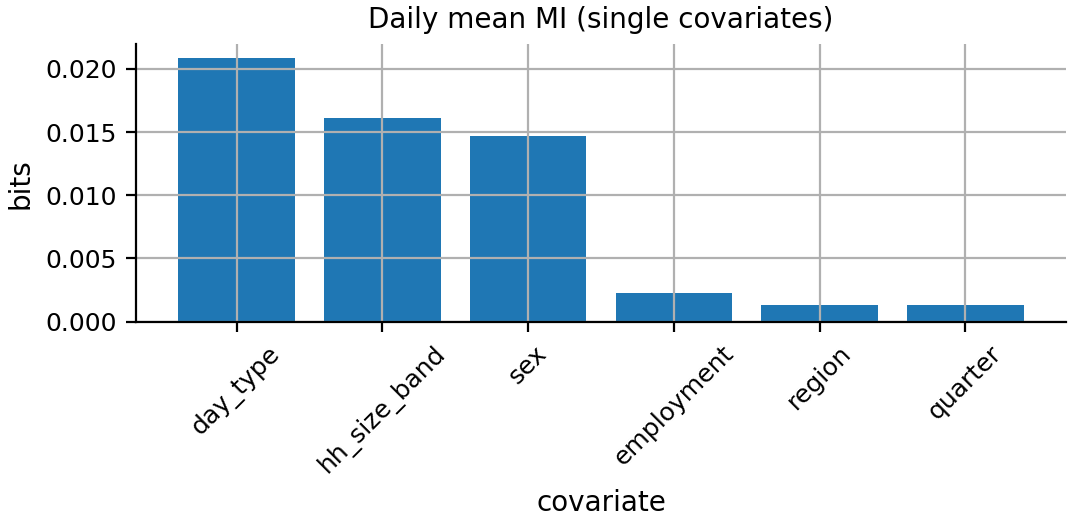

In [15]:
# === Cell 13: Cross-covariate info summary ===================================
summary_rows = []
for cov_name, obj in single_results.items():
    df_imp = obj["importance"]
    df_mi  = obj["MI"]
    sum_frob2 = df_imp["frob2_vs_overall"].sum()
    sum_symkl_bits = df_imp["symKL_vs_overall_bits"].sum()
    mi_mean = float(df_mi["MI_bits"].mean())
    mi_peak = float(df_mi["MI_bits"].max())
    summary_rows.append({
        "covariate": cov_name,
        "ΣFrobenius²": sum_frob2,
        "ΣSymKL (bits)": sum_symkl_bits,
        "MI_mean (bits)": mi_mean,
        "MI_peak (bits)": mi_peak,
    })
summary_df = pd.DataFrame(summary_rows).sort_values("MI_mean (bits)", ascending=False)
to_table(summary_df, "single_covariate_importance_summary")
display(summary_df)

fig, ax = plt.subplots(figsize=(INCH_COL1, 1.8))
ax.bar(summary_df["covariate"], summary_df["MI_mean (bits)"])
ax.set_title("Daily mean MI (single covariates)")
ax.set_ylabel("bits"); ax.set_xlabel("covariate")
ax.tick_params(axis="x", rotation=45)
fig.savefig(OUT_DIR / "single_covariate_MImean_bits.png", dpi=300)
plt.show()


In [16]:
# === Cell 14: Share-of-day tables per subgroup ===============================
def share_table(occ: np.ndarray, label: str):
    df = (pd.DataFrame({
        "state_id": np.arange(K),
        "state": [label_for(i) for i in range(K)],
        "share": occ.mean(axis=1),
        "minutes_per_day": occ.mean(axis=1) * 144 * 10
    }).sort_values("share", ascending=False))
    to_table(df, f"time_share_{label}")
    return df

share_table(occ_all, "overall")

for cov_name, cov in [("sex", sex), ("employment", employment), ("day_type", day_type),
                      ("region", region), ("hh_size_band", hh_size), ("quarter", quarter)]:
    for lv in sorted([x for x in cov.dropna().unique().tolist()]):
        m = mask_eq(cov, lv)
        if not m.any():
            continue
        occ = weighted_occupancy(states[m], w[m].to_numpy("float64"), K)
        share_table(occ, f"{cov_name}_{lv}")


In [17]:
# === Cell 15: QC bullets =====================================================
# Top states by minutes
top_minutes = (occ_all.mean(axis=1) * 144 * 10)
top_minutes = pd.Series(top_minutes, index=[label_for(i) for i in range(K)]).sort_values(ascending=False).head(10)
print("Top states by minutes/day:")
display(top_minutes)

# Largest between-group differences (Frobenius) across a few factors
biggest_diffs = []
for cov_name, cov in [("sex", sex), ("employment", employment), ("day_type", day_type),
                      ("region", region), ("hh_size_band", hh_size), ("quarter", quarter)]:
    levels = sorted([x for x in cov.dropna().unique().tolist()])
    occs = {}
    for lv in levels:
        m = mask_eq(cov, lv)
        if m.any():
            occs[lv] = weighted_occupancy(states[m], w[m].to_numpy("float64"), K)
    best = None
    for a, b in itertools.combinations(occs.keys(), 2):
        val = frobenius(occs[a], occs[b])
        if (best is None) or (val > best[0]):
            best = (val, a, b)
    if best:
        biggest_diffs.append({"factor":cov_name, "group_A":best[1], "group_B":best[2], "frobenius":best[0]})
qc_df = pd.DataFrame(biggest_diffs).sort_values("frobenius", ascending=False)
print("\nLargest between-group differences (Frobenius):")
display(qc_df)
to_table(qc_df, "qc_biggest_group_differences")


Top states by minutes/day:


SLEEP                       492.633306
OUT_OF_HOME                 389.570192
SCREENS_LEISURE             211.861238
QUIET_SOCIAL                 78.579891
EAT_DRINK                    69.062068
PERSONAL_CARE                48.401425
CARE_AT_HOME                 31.957403
APPLIANCE_HOUSEHOLD_ELEC     31.023728
COOKING                      28.831525
CLEANING_ELECTRIC            22.058449
dtype: float64


Largest between-group differences (Frobenius):


,factor,group_A,group_B,frobenius
2,day_type,Weekday,Weekend,2.321839
4,hh_size_band,1,4plus,1.418279
1,employment,NotInLF,Unemployed,1.417049
0,sex,Female,Male,0.923545
3,region,Northeast,West,0.392481
5,quarter,Q1,Q3,0.317218


(PosixPath('/ztank/scratch/user/u.rd143338/atus_analysis-main/atus_analysis/assets/tables/qc_biggest_group_differences.csv'),
 PosixPath('/ztank/scratch/user/u.rd143338/atus_analysis-main/atus_analysis/assets/tables/qc_biggest_group_differences.tex'))